tuto pour l'analyse de données de single cell RNA-seq avec Seurat :
https://satijalab.org/seurat/articles/pbmc3k_tutorial

In [70]:
library (Seurat)

library (dplyr)
library(ggplot2)
library(patchwork) # for arranging plots

library (viridisLite)
library (RColorBrewer)

#library (ggrastr)

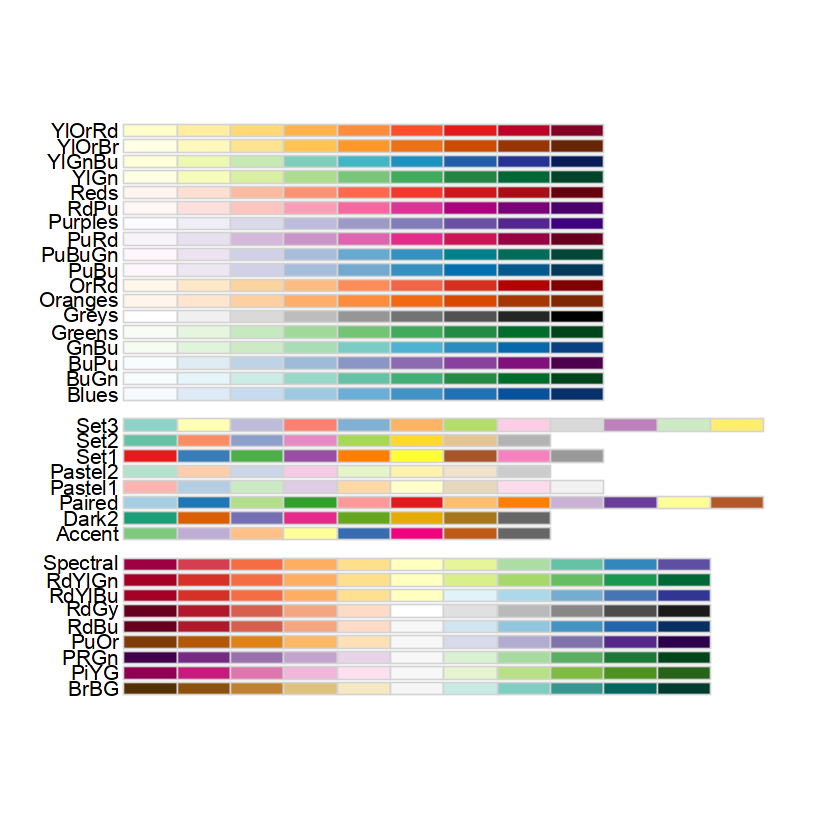

In [71]:
display.brewer.all()

# Cela affichera toutes les palettes de couleurs disponibles dans RColorBrewer. Les palettes sont divisées en trois catégories :
# 	•	Qualitative : pour des variables catégorielles (par exemple, Set1, Paired, Dark2, etc.).
# 	•	Sequential : pour des données ordonnées ou continues (par exemple, Blues, Reds, YlGnBu, etc.).
# 	•	Diverging : pour des données qui vont d’un extrême à un autre (par exemple, BrBG, RdBu, PiYG, etc.).

dans l'article : 

“Processing of B. subtilis data from the growth in rich media experiment Clustering and data analysis for the combined 10 samples of B. subtilis grown in rich medium was performed using Scanpy (59) and verified with Seurat v3 (61) and UNCURL (62). Experiment 1 sampled OD points 0.5, 1.0, 1.7, 2.0, 2.8, and 3.2, whereas in experiment 2, we collected OD points 0.5, 1.0, 1.3, 1.7, 2.8, 3.5, 5.3, and 6.0. For the data from both experiments separately, we discarded any transcriptomes that had a number of total reads fewer than 200. Then, we filtered the data and retained only reads representing the mRNA counts (excluding the ribosomal and tRNA reads). Finally, we combined the data matrices together. Because the read depth decreased for the higher OD samples (fig. S26), for selecting the highest quality data, we implemented differential thresholds for each OD in the combined matrix, retaining the top 75% of the cells by read counts for each OD sample. This resulted in retention of 25,214 transcriptomes from both experiments. Finally, we performed batch correction through Scanpy, using a python implementation of ComBat (63, 64). Cells that passed the QC were clustered using a pipeline described in previous studies (7, 60).” ([Kuchina et al., 2021, p. 8])



Le pipeline de traitement des données de Bacillus subtilis dans l’expérience de croissance en milieu riche, tel que décrit par Kuchina et al. (2021), suit plusieurs étapes clés de filtrage et d’analyse :

⸻

1. Acquisition des échantillons

Les auteurs ont réalisé deux expériences indépendantes, chacune avec des mesures d’OD (densité optique) à différentes phases de croissance :
	•	Expérience 1 : OD = 0.5, 1.0, 1.7, 2.0, 2.8, 3.2
	•	Expérience 2 : OD = 0.5, 1.0, 1.3, 1.7, 2.8, 3.5, 5.3, 6.0

Cela signifie qu’ils ont échantillonné les bactéries à différents stades de croissance pour capturer les changements transcriptionnels.

⸻

2. Filtrage des cellules et des reads

Avant d’analyser les données, plusieurs filtres ont été appliqués :

a) Seuil de reads total
	•	Les transcriptomes avec moins de 200 reads au total ont été exclus.
👉 Cela permet d’éliminer les cellules de mauvaise qualité avec une couverture trop faible.

b) Sélection des reads d’intérêt
	•	Seuls les reads représentant des ARNm ont été conservés.
	•	Les reads de l’ARN ribosomal (rRNA) et de l’ARN de transfert (tRNA) ont été exclus.
👉 Cette étape est cruciale, car les ARN non codants peuvent dominer les séquences brutes et fausser l’analyse.

c) Normalisation de la profondeur de lecture (read depth)
	•	Ils ont remarqué que la profondeur de lecture diminue aux ODs élevées (Figure S26).
	•	Pour garantir une qualité uniforme des données, ils ont appliqué des seuils différenciés en fonction des OD.
	•	Seules les 75% des cellules ayant le plus de reads ont été conservées pour chaque OD.
👉 Cela garantit que seules les cellules les mieux séquencées sont utilisées.

d) Fusion des matrices
	•	Une fois les données filtrées, les matrices des deux expériences ont été combinées.

⸻

3. Correction de batch et clustering
	•	Une correction de batch a été appliquée avec Scanpy, en utilisant ComBat (implémentation en Python).
👉 Cela corrige les effets de lot pour rendre les données comparables entre les expériences.
	•	Clustering des cellules :
	•	Utilisation de Scanpy (outil principal).
	•	Vérification des clusters avec Seurat v3 et UNCURL.
	•	Application d’un pipeline de clustering basé sur des études précédentes.

⸻

Résumé du pipeline
	1.	Échantillonnage à différentes OD dans deux expériences.
	2.	Filtrage des cellules (seuil de 200 reads).
	3.	Élimination des ARN ribosomaux et de transfert.
	4.	Normalisation en conservant les 75% des meilleures cellules par OD.
	5.	Fusion des matrices de données des deux expériences.
	6.	Correction de batch avec ComBat (Scanpy).
	7.	Clustering avec Scanpy, Seurat et UNCURL.

⸻

👉 Pourquoi ce pipeline ?
L’objectif est de garantir une analyse robuste des transcriptomes bactériens en supprimant les biais liés aux différences de qualité des cellules et des expériences.

j'ai utilisé leur script modifie pour mettre un threshold de 0 pour conserver l'ensembles des counts  : dans l'autre article les auteurs utilise un filtre avec un threshold pour ne garder que les meilleurs 
de plus je filtre les mRNA dès le debut avec cette fonction 

ici : j'ai deja combiné les resultats de sequençages des 2 repetitions de l'expérience en un seul objet seurat : rep1 et rep2 
avec Seurat V5 c'est possible de combiner les objets seurat de 2 expériences differentes en un seul objet seurat pout faire des analyses en commun 

 

In [72]:
# Import the data de données mRNAs non filtrées
# load the Seurat object
path_RNA_combined  <- "7_Article/results/tab_seurat_correct/RNA_combined.rds"
RNA_combined <- readRDS(path_RNA_combined)
seurat_obj <- RNA_combined

In [73]:
seurat_obj

An object of class Seurat 
4422 features across 730249 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

730249 samples 
Cela signifie qu'il  y a 730249 cellules potentielles dans l'objet seurat_obj 
On aura besoin de filtre pour identifier les "vrai cellules"

In [74]:
str (seurat_obj)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 2
  .. .. .. .. ..$ counts.1:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:2034849] 4110 70 2747 1635 1759 1838 2420 3003 161 675 ...
  .. .. .. .. .. .. ..@ p       : int [1:300075] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 4422 300074
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:2034849] 0.111 0.167 2 0.333 0.333 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ counts.2:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:11781869] 617 845 848 1346 2735 2819 2825 2924 3200 4020 ...
  .. .. .. .. .. .. ..@ p       : int [1:430176] 0 0 12 12 12 64 72 73

In [75]:
#head (seurat_obj)
#tail (seurat_obj)
View(seurat_obj@meta.data)

,nCount_RNA,nFeature_RNA,rep,sublibrary,well,cond
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
rep1_AAACATCG_AACCGAGA_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AACGCTTA_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AACTCACC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AATCCGTC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_ACAGATTC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AGCACCTC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AGCAGGAA_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AGCCATGC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5
rep1_AAACATCG_AGGCTAAC_ACTCGTAA,0.000000,0,rep1,M15,A1,OD0.5


In [76]:
Assays(RNA_combined)  # Pour voir les assays disponibles

[1] "RNA"

In [77]:
Layers(RNA_combined) # check the layers

[1] "counts.1" "counts.2"

In [78]:
print ("ncount RNA : ")
summary(seurat_obj$nCount_RNA)  # Statistiques de nCount_RNA
print ("nfeature RNA : ")
summary(seurat_obj$nFeature_RNA)  # Statistiques de nFeature_RNA

[1] "ncount RNA : "


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.000     0.250     2.000    20.795     6.167 14420.359 

[1] "nfeature RNA : "


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    4.00   18.92   12.00 2615.00 

Il y a beaucoup de cellules avec 0 counts, il faut les filtrer 
on ne peut meme pas faire de graph car trop de points et surtout beaucoup de 0 

# fait un filtre sur les cellules 
🛠 Explication :
	•	subset = nCount_RNA >= 200 → Garde uniquement les cellules où le total des reads (UMIs) est supérieur ou égal à 200.
	•	subset() est la fonction recommandée pour filtrer les objets Seurat.

In [79]:
subset(seurat_obj, subset = nCount_RNA >= 200) # permet de voir rapidement les resultats du subset

seurat_obj_f <- subset(seurat_obj, subset = nCount_RNA >= 200)  # Filtrer les cellules avec un nombre de gènes exprimés >= 200    
#Filtering cells based on number of UMIs by cell


seurat_obj_f
print ("ncount RNA : ")
summary(seurat_obj_f$nCount_RNA)  # Statistiques de nCount_RNA
print ("nfeature RNA : ")
summary(seurat_obj_f$nFeature_RNA)  # Statistiques de nFeature_RNA


An object of class Seurat 
4422 features across 14963 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

An object of class Seurat 
4422 features across 14963 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

[1] "ncount RNA : "


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  200.1   297.1   462.3   693.8   812.2 14420.4 

[1] "nfeature RNA : "


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  130.0   253.0   353.0   438.3   533.0  2615.0 

In [80]:
# 4422 features across 14963 samples 
#avec ce simple filtre on ne garde plus que 14963 cellules potentielles
# 4422 sont les gènes exprimés dans ces cellules

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


[[1]]

[[2]]


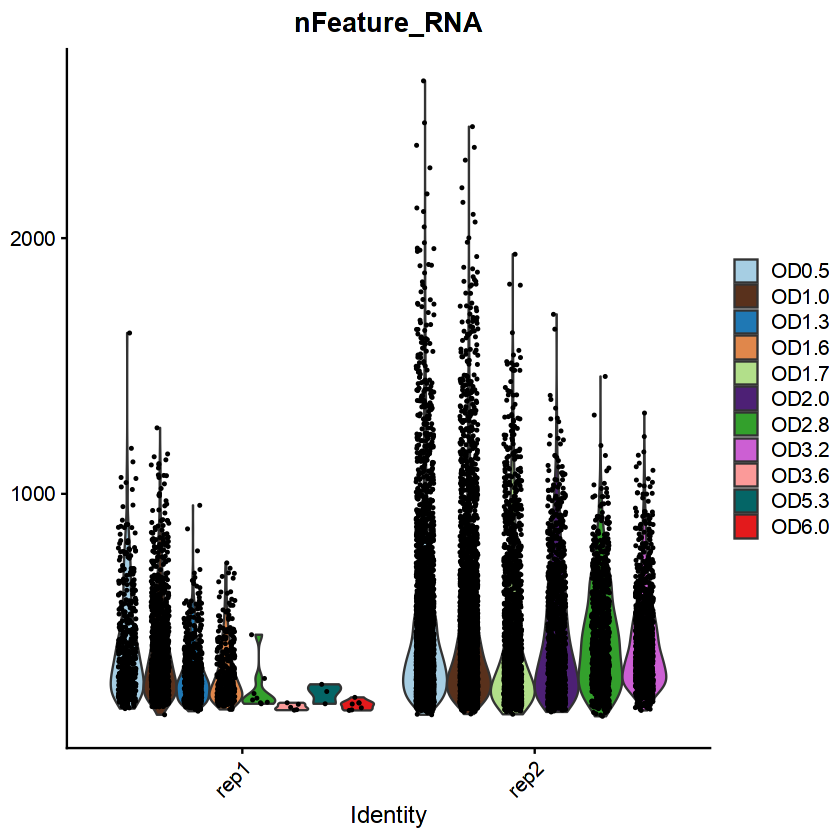

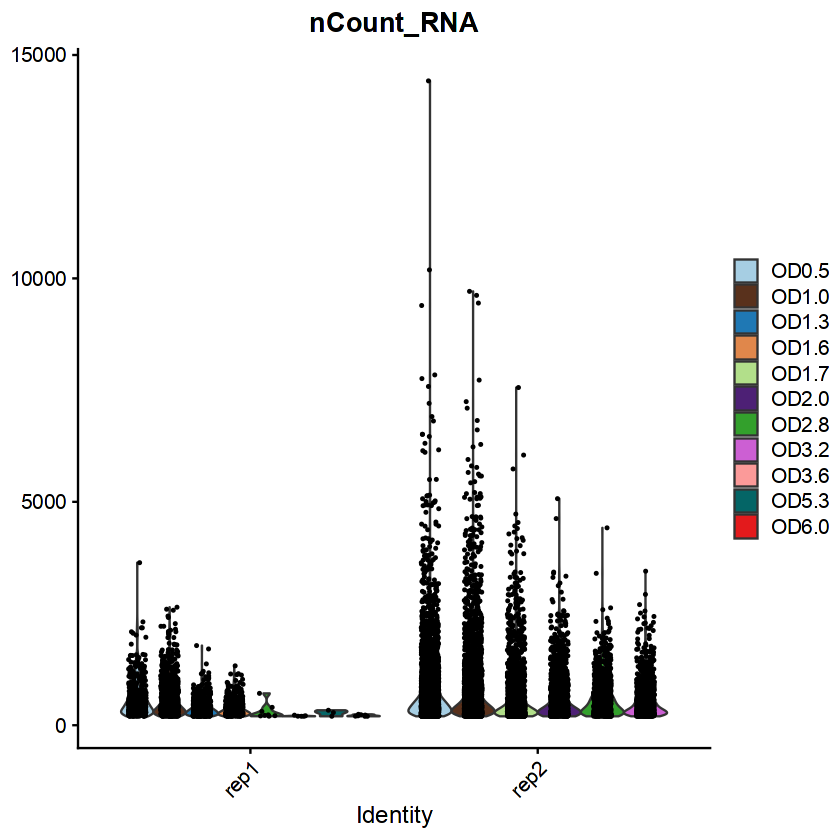

In [81]:

VlnPlot(
  object = seurat_obj_f,             # Objet Seurat contenant les données à analyser
  features =c("nFeature_RNA", "nCount_RNA"),           # Les caractéristiques à afficher (par exemple, l'expression génique, les scores PC, etc.)
  cols = brewer.pal(8, "Paired"),        # Couleurs à utiliser pour l'affichage
  pt.size = NULL,     # Taille des points (pour les points individuels)
  alpha = 1,          # Transparence des points (valeur entre 0 et 1)
  idents = NULL,      # Classes à inclure dans le graphique (par défaut, toutes les classes sont affichées)
  sort = FALSE,       # Tri des classes d'identité sur l'axe des X selon l'expression moyenne de l'attribut
  assay = NULL,       # Nom de l'assai à utiliser (par défaut, l'assai actif)
  group.by = "rep",    # Groupe (ou couleur) des cellules selon une variable (ex : identifiant d'échantillon)
  split.by = "cond",    # Facteur dans les métadonnées de l'objet pour diviser l'affichage (ex : identité de cellule)
  adjust = 1,         # Paramètre d'ajustement pour la fonction `geom_violin`
  y.max = NULL,       # Valeur maximale de l'axe des Y
  same.y.lims = FALSE, # Appliquer les mêmes limites d'axe Y pour toutes les cellules
  log = FALSE,        # Appliquer une échelle logarithmique à l'axe des Y
  ncol = 2,        # Nombre de colonnes à afficher si plusieurs graphiques sont combinés
 #
  layer = NULL,       # Couche des données à afficher (ex : "counts" ou "data")
  split.plot = FALSE, # Diviser les violons en plusieurs formes pour chaque groupe
  stack = FALSE,      # Empiler les graphiques pour chaque caractéristique sur l'axe X
  combine = FALSE,     # Combiner les graphiques en un seul objet ggplot (FALSE pour une liste de ggplots séparés)
  fill.by = "feature",# Remplir les violons selon la caractéristique ou l'identité
  flip = FALSE,       # Inverser l'orientation du graphique (identités sur l'axe des X)
  add.noise = TRUE,   # Ajouter un petit bruit pour la visualisation des points
  raster = NULL       # Convertir les points en format raster (nécessite l'installation de 'ggrastr')
)

probleme d'affichage pour les couleurs :  lié au nombre de categories trop importantes par rapport au nombre de couleurs disponibles dans la palette , donc la fonction ne va pas afficher la palette souhaité

on remarque que plus la DO est importante plus la profondeur de sequençage est faible (on detecte moins de genes et moins de reads (UMIs))

de plus on remarque que cette profondeur de sequençage est plus importante pour la rep2 
les DO les plus elevés de la rep1 possèdent des profondeurs de sequençage plus faibles qui ne sont probablement pas suffisantes pour une analyse de single cell RNA seq , je vais decider de les retirer

In [82]:
# avant le filtre on avait 14963 cellules 

# An object of class Seurat 
# 4422 features across 14963 samples within 1 assay 
# Active assay: RNA (4422 features, 0 variable features)
#  2 layers present: counts.1, counts.2


subset(seurat_obj_f, 
    subset = 
        nFeature_RNA > 200 # au moins 200 gènes exprimés par cellule est probablement trop restrictif
        & nFeature_RNA < 6000 # au max 6000 gènes exprimés par cellule ( de toute façon, on a max 2615 gènes detectés au max dans une cellule unique) et on possède 4422 gènes ARNm (4422 features) donc on ne peut pas avoir plus de 4422 gènes exprimés par cellule
        &
         nCount_RNA > 200  # au moins 200 UMIs par cellule
        & nCount_RNA < 10000 # au max 10000 UMIs par cellule
        )
#filtre avec nCount_RNA < 10000 et nFeature_RNA > 200 en plus 

# An object of class Seurat 
# 4422 features across 13455 samples within 1 assay 
# Active assay: RNA (4422 features, 0 variable features)
#  2 layers present: counts.1, counts.2

#et après le filtre on a 13455 cellules

subset(seurat_obj_f, 
    subset = 
        nFeature_RNA > 150 # au moins 200 gènes exprimés par cellule est probablement trop restrictif
        & nFeature_RNA < 6000 # au max 6000 gènes exprimés par cellule ( de toute façon, on a max 2615 gènes detectés au max dans une cellule unique) et on possède 4422 gènes ARNm (4422 features) donc on ne peut pas avoir plus de 4422 gènes exprimés par cellule
        &
         nCount_RNA > 200  # au moins 200 UMIs par cellule
        & nCount_RNA < 10000 # au max 10000 UMIs par cellule
        )
#et après le filtre on a 14960 cellules

An object of class Seurat 
4422 features across 13455 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

An object of class Seurat 
4422 features across 14940 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

In [83]:

# An object of class Seurat 
# 4422 features across 14963 samples within 1 assay 
# Active assay: RNA (4422 features, 0 variable features)
#  2 layers present: counts.1, counts.2
# [1] "ncount RNA : "
#    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#   200.1   297.1   462.3   693.8   812.2 14420.4 
# [1] "nfeature RNA : "
#    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#   130.0   253.0   353.0   438.3   533.0  2615.0 

#130 gènes exprimés au minimum par cellule
#2615 gènes exprimés au maximum par cellule
#200 UMIs au minimum par cellule
#14420 UMIs au maximum par cellule

subset(seurat_obj_f, 
    subset = 
        # nFeature_RNA > 200 # au moins 200 gènes exprimés par cellule est probablement trop restrictif
        #& nFeature_RNA < 6000 # au max 6000 gènes exprimés par cellule ( de toute façon, on a max 2615 gènes detectés au max dans une cellule unique) et on possède 4422 gènes ARNm (4422 features) donc on ne peut pas avoir plus de 4422 gènes exprimés par cellule
        #&
         nCount_RNA > 200  # au moins 200 UMIs par cellule
        & nCount_RNA < 10000 # au max 10000 UMIs par cellule
        )
        # Filtrer les cellules avec un nombre de gènes exprimés entre 200 et 6000 et un nombre d'UMIs entre 800 et 20000

seurat_obj_f2 <- subset(seurat_obj_f, 
    subset = 
        # nFeature_RNA > 200 # au moins 200 gènes exprimés par cellule est probablement trop restrictif
        #& nFeature_RNA < 6000 # au max 6000 gènes exprimés par cellule ( de toute façon, on a max 2615 gènes detectés au max dans une cellule unique) et on possède 4422 gènes ARNm (4422 features) donc on ne peut pas avoir plus de 4422 gènes exprimés par cellule
        #&
        nCount_RNA > 200  # au moins 200 UMIs par cellule
        & nCount_RNA < 10000 # au max 10000 UMIs par cellule
        )
        # Filtrer les cellules avec un nombre de gènes exprimés entre 200 et 6000 et un nombre d'UMIs entre 800 et 20000

seurat_obj_f2

An object of class Seurat 
4422 features across 14961 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

An object of class Seurat 
4422 features across 14961 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2

An object of class Seurat 
4422 features across 14961 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 2 layers present: counts.1, counts.2


VlnPlot(
  object = RNA_combined,             # Objet Seurat contenant les données à analyser
  features =c("nFeature_RNA", "nCount_RNA"),           # Les caractéristiques à afficher (par exemple, l'expression génique, les scores PC, etc.)
  cols = brewer.pal(8, "Paired"),        # Couleurs à utiliser pour l'affichage
  pt.size = NULL,     # Taille des points (pour les points individuels)
  alpha = 1,          # Transparence des points (valeur entre 0 et 1)
  idents = NULL,      # Classes à inclure dans le graphique (par défaut, toutes les classes sont affichées)
  sort = FALSE,       # Tri des classes d'identité sur l'axe des X selon l'expression moyenne de l'attribut
  assay = NULL,       # Nom de l'assai à utiliser (par défaut, l'assai actif)
  group.by = "rep",    # Groupe (ou couleur) des cellules selon une variable (ex : identifiant d'échantillon)
  split.by = "cond",    # Facteur dans les métadonnées de l'objet pour diviser l'affichage (ex : identité de cellule)
  adjust = 1,         # Paramètre d'ajustement pour la fonction `geom_violin`
  y.max = NULL,       # Valeur maximale de l'axe des Y
  same.y.lims = FALSE, # Appliquer les mêmes limites d'axe Y pour toutes les cellules
  log = FALSE,        # Appliquer une échelle logarithmique à l'axe des Y
  ncol = 2,        # Nombre de colonnes à afficher si plusieurs graphiques sont combinés
 #
  layer = NULL,       # Couche des données à afficher (ex : "counts" ou "data")
  split.plot = FALSE, # Diviser les violons en plusieurs formes pour chaque groupe
  stack = TRUE,      # Empiler les graphiques pour chaque caractéristique sur l'axe X
  combine = FALSE,     # Combiner les graphiques en un seul objet ggplot (FALSE pour une liste de ggplots séparés)
  fill.by = "feature",# Remplir les violons selon la caractéristique ou l'identité
  flip = FALSE,       # Inverser l'orientation du graphique (identités sur l'axe des X)
  add.noise = TRUE,   # Ajouter un petit bruit pour la visualisation des points
  raster = NULL       # Convertir les points en format raster (nécessite l'installation de 'ggrastr')
)

# Ce code génère un graphique en violon avec les caractéristiques spécifiées. Il permet de visualiser la distribution de l’expression d’un ou plusieurs gènes (ou d’autres mesures) pour différentes classes de cellules dans un objet Seurat, avec des options de personnalisation telles que la couleur, le tri des classes, l’ajustement des axes, etc.

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


[[1]]

[[2]]


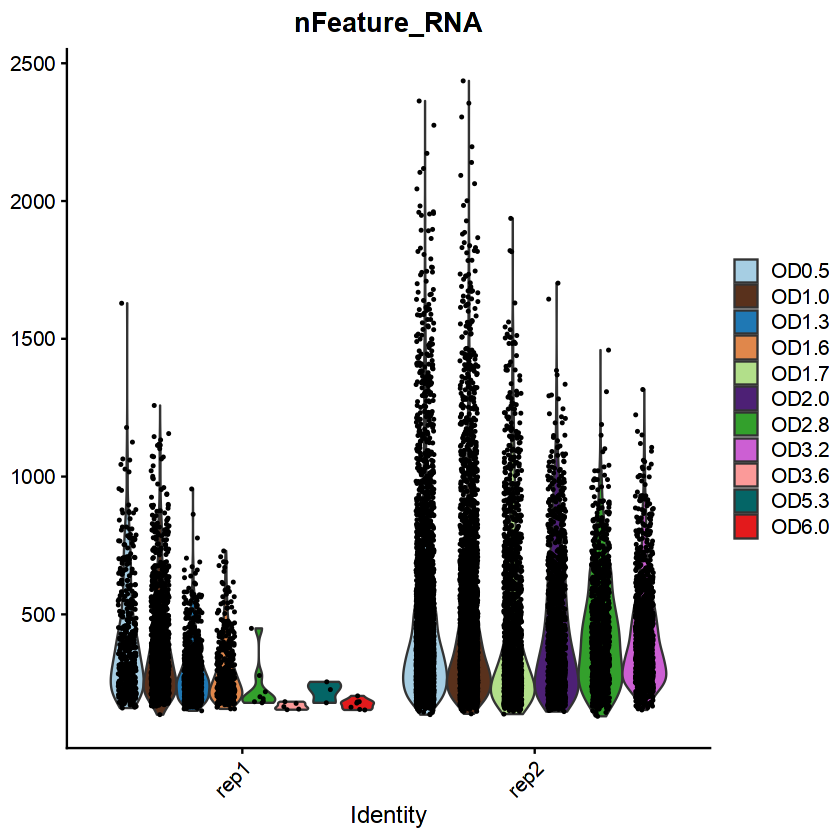

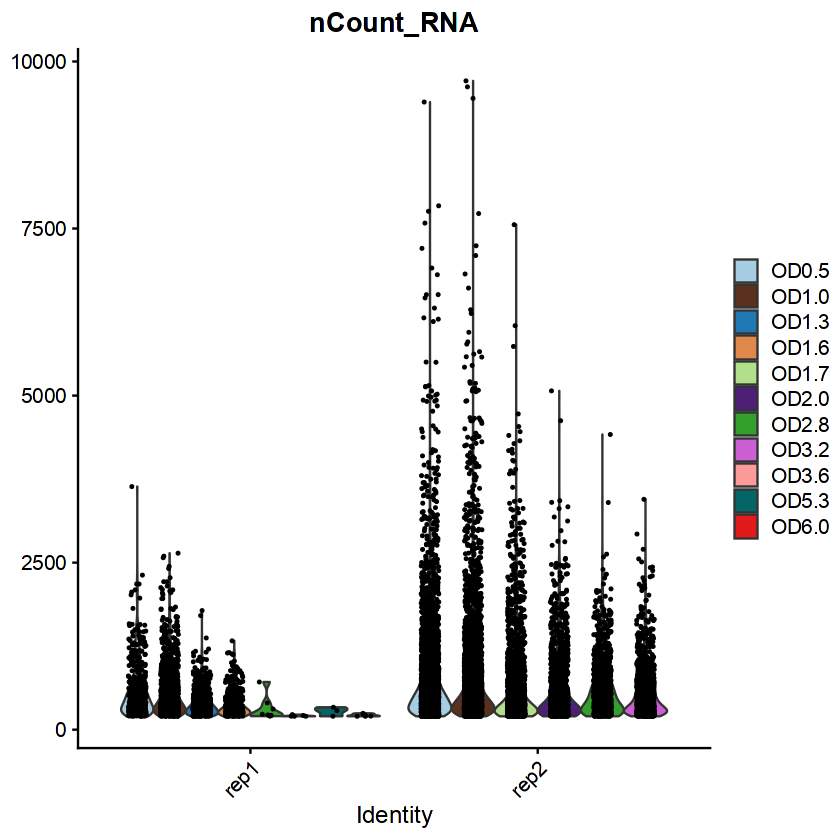

In [84]:

VlnPlot(
  object = seurat_obj_f2,             # Objet Seurat contenant les données à analyser
  features =c("nFeature_RNA", "nCount_RNA"),           # Les caractéristiques à afficher (par exemple, l'expression génique, les scores PC, etc.)
  cols = brewer.pal(8, "Paired"),        # Couleurs à utiliser pour l'affichage
  pt.size = NULL,     # Taille des points (pour les points individuels)
  alpha = 1,          # Transparence des points (valeur entre 0 et 1)
  idents = NULL,      # Classes à inclure dans le graphique (par défaut, toutes les classes sont affichées)
  sort = FALSE,       # Tri des classes d'identité sur l'axe des X selon l'expression moyenne de l'attribut
  assay = NULL,       # Nom de l'assai à utiliser (par défaut, l'assai actif)
  group.by = "rep",    # Groupe (ou couleur) des cellules selon une variable (ex : identifiant d'échantillon)
  split.by = "cond",    # Facteur dans les métadonnées de l'objet pour diviser l'affichage (ex : identité de cellule)
  adjust = 1,         # Paramètre d'ajustement pour la fonction `geom_violin`
  y.max = NULL,       # Valeur maximale de l'axe des Y
  same.y.lims = FALSE, # Appliquer les mêmes limites d'axe Y pour toutes les cellules
  log = FALSE,        # Appliquer une échelle logarithmique à l'axe des Y
  ncol = 2,        # Nombre de colonnes à afficher si plusieurs graphiques sont combinés
 #
  layer = NULL,       # Couche des données à afficher (ex : "counts" ou "data")
  split.plot = FALSE, # Diviser les violons en plusieurs formes pour chaque groupe
  stack = FALSE,      # Empiler les graphiques pour chaque caractéristique sur l'axe X
  combine = FALSE,     # Combiner les graphiques en un seul objet ggplot (FALSE pour une liste de ggplots séparés)
  fill.by = "feature",# Remplir les violons selon la caractéristique ou l'identité
  flip = FALSE,       # Inverser l'orientation du graphique (identités sur l'axe des X)
  add.noise = TRUE,   # Ajouter un petit bruit pour la visualisation des points
  raster = NULL       # Convertir les points en format raster (nécessite l'installation de 'ggrastr')
)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“'ncol' is ignored with 'stack' is TRUE”


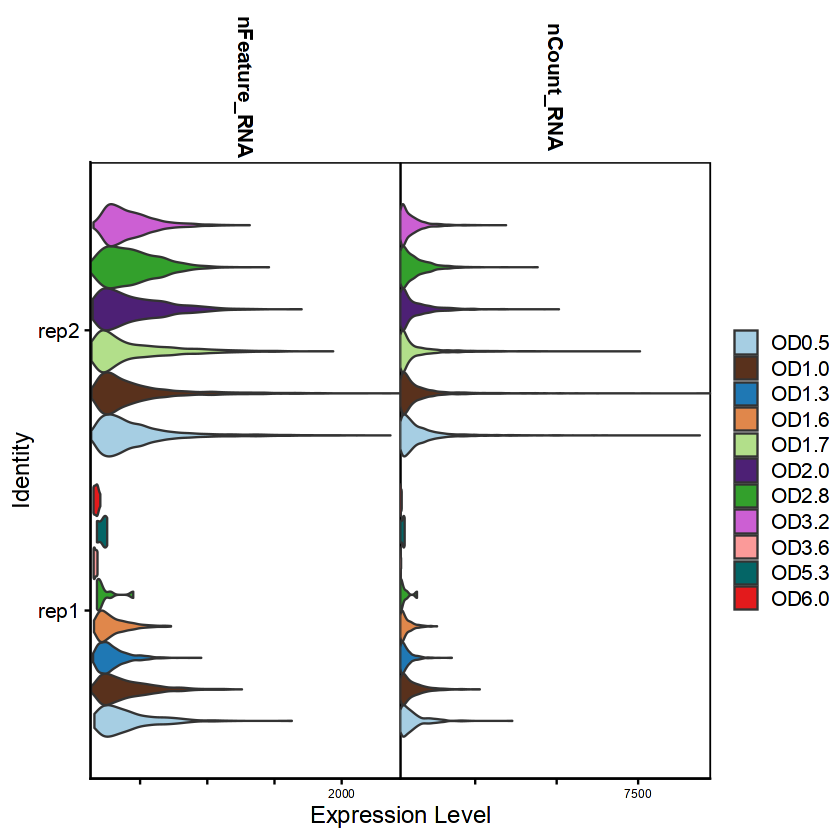

In [85]:

VlnPlot(
  object = seurat_obj_f2,             # Objet Seurat contenant les données à analyser
  features =c("nFeature_RNA", "nCount_RNA"),           # Les caractéristiques à afficher (par exemple, l'expression génique, les scores PC, etc.)
  cols = brewer.pal(8, "Paired"),        # Couleurs à utiliser pour l'affichage
  pt.size = NULL,     # Taille des points (pour les points individuels)
  alpha = 1,          # Transparence des points (valeur entre 0 et 1)
  idents = NULL,      # Classes à inclure dans le graphique (par défaut, toutes les classes sont affichées)
  sort = FALSE,       # Tri des classes d'identité sur l'axe des X selon l'expression moyenne de l'attribut
  assay = NULL,       # Nom de l'assai à utiliser (par défaut, l'assai actif)
  group.by = "rep",    # Groupe (ou couleur) des cellules selon une variable (ex : identifiant d'échantillon)
  split.by = "cond",    # Facteur dans les métadonnées de l'objet pour diviser l'affichage (ex : identité de cellule)
  adjust = 1,         # Paramètre d'ajustement pour la fonction `geom_violin`
  y.max = NULL,       # Valeur maximale de l'axe des Y
  same.y.lims = FALSE, # Appliquer les mêmes limites d'axe Y pour toutes les cellules
  log = FALSE,        # Appliquer une échelle logarithmique à l'axe des Y
  ncol = 2,        # Nombre de colonnes à afficher si plusieurs graphiques sont combinés
 #
  layer = NULL,       # Couche des données à afficher (ex : "counts" ou "data")
  split.plot = FALSE, # Diviser les violons en plusieurs formes pour chaque groupe
  stack = TRUE,      # Empiler les graphiques pour chaque caractéristique sur l'axe X
  combine = FALSE,     # Combiner les graphiques en un seul objet ggplot (FALSE pour une liste de ggplots séparés)
  fill.by = "feature",# Remplir les violons selon la caractéristique ou l'identité
  flip = FALSE,       # Inverser l'orientation du graphique (identités sur l'axe des X)
  add.noise = TRUE,   # Ajouter un petit bruit pour la visualisation des points
  raster = FALSE       # Convertir les points en format raster (nécessite l'installation de 'ggrastr')
)

# Ce code génère un graphique en violon avec les caractéristiques spécifiées. Il permet de visualiser la distribution de l’expression d’un ou plusieurs gènes (ou d’autres mesures) pour différentes classes de cellules dans un objet Seurat, avec des options de personnalisation telles que la couleur, le tri des classes, l’ajustement des axes, etc.

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


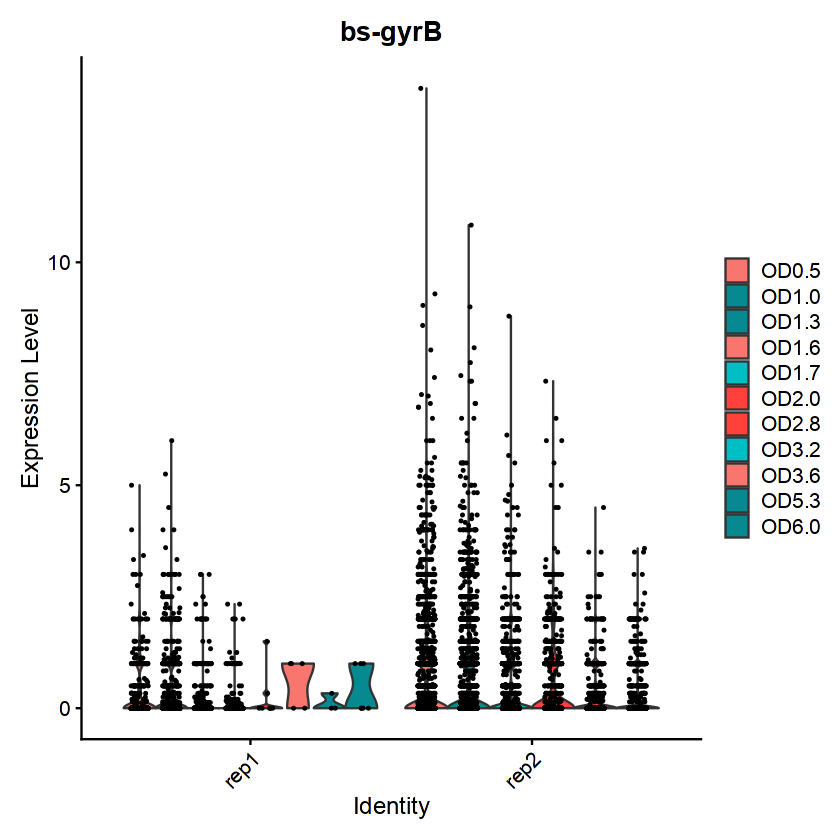

In [86]:
VlnPlot(object = seurat_obj_f2, 
        features = "bs-gyrB", 
        group.by = "rep", 
        split.by = "cond")

FeatureScatter(
  object,       # Objet Seurat contenant les données de single-cell RNA-seq.
  feature1,     # Premier paramètre à représenter sur l'axe X (expression d'un gène, métrique, PC score...).
  feature2,     # Deuxième paramètre à représenter sur l'axe Y.

  cells = NULL,     # Liste des cellules à inclure dans le scatter plot (par défaut, toutes les cellules).
  shuffle = FALSE,  # Si TRUE, mélange aléatoirement les points pour éviter qu'ils se chevauchent.
  seed = 1,         # Fixe la graine aléatoire pour la reproductibilité (utile avec shuffle = TRUE).

  group.by = NULL,  # Nom d'une colonne des métadonnées pour colorer les cellules (ex : "orig.ident").
  split.by = NULL,  # Colonne des métadonnées pour séparer le graphique en plusieurs sous-groupes.
  cols = NULL,      # Couleurs utilisées pour afficher les différentes classes d'identité.

  pt.size = 1,      # Taille des points sur le graphique.
  shape.by = NULL,  # (Non utilisé actuellement).

  span = NULL,      # Si défini, ajoute un lissage Loess (Spline) aux données.
  smooth = FALSE,   # Ajoute un effet de lissage sur le scatter plot (similaire à `smoothScatter`).

  combine = TRUE,   # Si TRUE, combine plusieurs graphiques en un seul (sinon, retourne une liste de ggplots).

  slot = "data",    # Emplacement des données dans l'objet Seurat : "counts", "data" ou "scale.data".
  plot.cor = TRUE,  # Affiche la corrélation entre feature1 et feature2 dans le titre du graphique.

  ncol = NULL,      # Nombre de colonnes si plusieurs graphiques sont affichés.

  raster = NULL,        # Convertit les points en format raster (utile pour les grands jeux de données).
  raster.dpi = c(512, 512),  # Résolution en pixels des plots rasterisés.

  jitter = FALSE,  # Ajoute du jitter (légère dispersion aléatoire des points) pour mieux visualiser les points superposés.
  log = FALSE      # Si TRUE, applique une échelle logarithmique aux axes.
)





Voici un commentaire détaillé en français de la fonction NormalizeData() de Seurat :

⸻

🔍 Description

La fonction NormalizeData() normalise les données de comptage brutes présentes dans un objet Seurat ou un assay spécifique.
Elle permet d’appliquer différentes méthodes de normalisation pour rendre les données comparables entre cellules.

⸻

📌 Arguments

🔹 object

Objet Seurat, Assay ou matrice de comptage (V3Matrix) à normaliser.

🔹 normalization.method (par défaut = "LogNormalize")

Méthode de normalisation à appliquer :
	•	"LogNormalize" (par défaut) :
	•	Divise les comptages bruts de chaque cellule par le total des comptages de cette cellule.
	•	Multiplie par un facteur d’échelle (scale.factor).
	•	Applique une transformation log1p (logarithme naturel après ajout de 1).
	•	"CLR" (Centered Log Ratio) :
	•	Normalisation basée sur le log-ratio centré.
	•	Utilisé souvent pour des données compositionnelles (ex. microbiome, métagénomique).
	•	Le paramètre margin contrôle si la normalisation est faite par gène (1) ou par cellule (2).
	•	"RC" (Relative Counts) :
	•	Divise les comptages bruts de chaque cellule par le total des comptages de cette cellule.
	•	Multiplie par un facteur d’échelle (scale.factor).
	•	❌ Pas de transformation logarithmique.
	•	Permet d’obtenir des Counts Per Million (CPM) en fixant scale.factor = 1e6.

🔹 scale.factor (par défaut = 10000)

Facteur de mise à l’échelle appliqué après la division des comptes par le total cellulaire.
	•	Par défaut (10000), les valeurs normalisées sont proportionnelles à 10 000 UMI par cellule.
	•	Peut être changé selon l’échelle des données (ex. 1e6 pour CPM).

🔹 margin (par défaut = 1)
	•	Utilisé uniquement pour la méthode "CLR".
	•	Spécifie l’axe de normalisation :
	•	1 : Normalisation par gène (features).
	•	2 : Normalisation par cellule.

🔹 block.size (par défaut = NULL)
	•	Nombre de cellules traitées en parallèle lors de la normalisation.
	•	Permet d’optimiser la mémoire et la vitesse en mode multithread.

🔹 verbose (par défaut = TRUE)
	•	Affiche une barre de progression pour suivre l’avancement de la normalisation.
	•	Utile si le jeu de données est volumineux.

🔹 assay (par défaut = NULL)
	•	Nom de l’assay à normaliser dans un objet Seurat.
	•	Si NULL, utilise l’assay actif (DefaultAssay(object)).

⸻

🛠 Exemple d’utilisation

1️⃣ Normalisation standard (LogNormalize)

RNA_combined <- NormalizeData(RNA_combined)

➡️ Normalisation avec "LogNormalize" (méthode par défaut) et scale.factor = 10 000.

2️⃣ Normalisation avec Centered Log Ratio (CLR)

RNA_combined <- NormalizeData(RNA_combined, normalization.method = "CLR", margin = 1)

➡️ Applique CLR sur chaque gène (margin = 1).

3️⃣ Normalisation en CPM (Counts Per Million)

RNA_combined <- NormalizeData(RNA_combined, normalization.method = "RC", scale.factor = 1e6)

➡️ Transforme les données en CPM (pas de log-transformation).

⸻

🎯 Conclusion
	•	NormalizeData() transforme les comptages bruts en valeurs comparables entre cellules.
	•	Elle propose trois méthodes (LogNormalize, CLR, RC) adaptées à différents besoins.
	•	LogNormalize est le choix par défaut car il atténue les effets de variation de profondeur de séquençage.

🔹 À retenir :
✅ Toujours normaliser avant toute analyse (clustering, PCA, UMAP, etc.).
✅ La méthode dépend du type d’analyse (scRNA-seq, métagénomique…).
✅ scale.factor et margin permettent d’ajuster la normalisation selon les besoins. 🚀

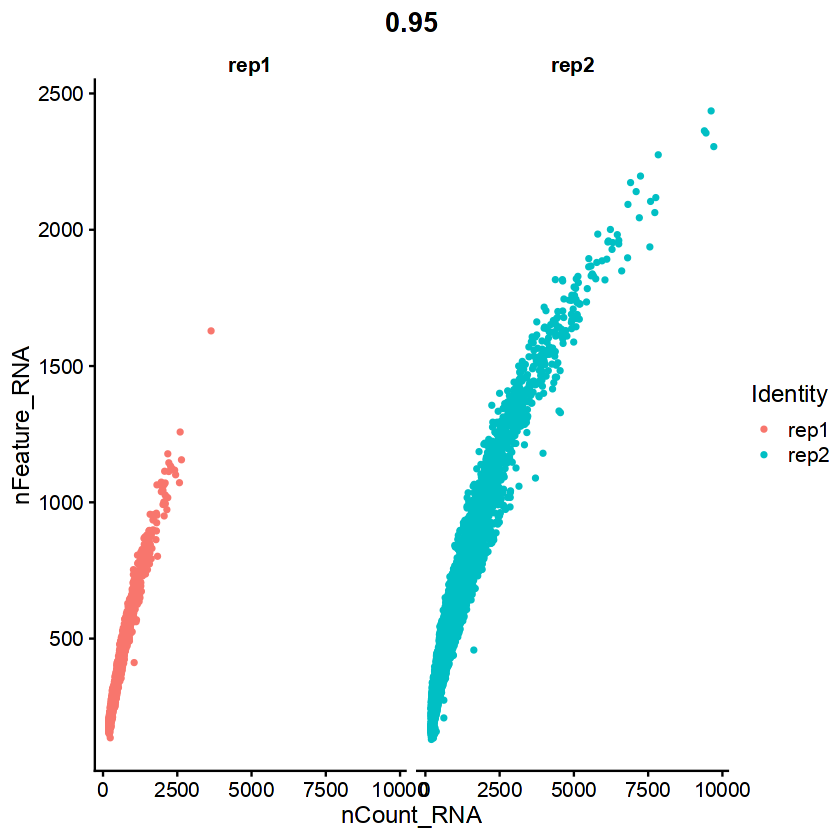

In [87]:
FeatureScatter(
  object = seurat_obj_f2,       # Objet Seurat contenant les données de single-cell RNA-seq.
  feature1 = "nCount_RNA",     # Premier paramètre à représenter sur l'axe X (expression d'un gène, métrique, PC score...).
  feature2 = "nFeature_RNA",     # Deuxième paramètre à représenter sur l'axe Y.

  cells = NULL,     # Liste des cellules à inclure dans le scatter plot (par défaut, toutes les cellules).
  shuffle = FALSE,  # Si TRUE, mélange aléatoirement les points pour éviter qu'ils se chevauchent.
  seed = 1,         # Fixe la graine aléatoire pour la reproductibilité (utile avec shuffle = TRUE).

  group.by = "rep",  # Nom d'une colonne des métadonnées pour colorer les cellules (ex : "orig.ident").
  split.by = "rep",  # Colonne des métadonnées pour séparer le graphique en plusieurs sous-groupes.
  cols = NULL,      # Couleurs utilisées pour afficher les différentes classes d'identité.

  pt.size = 1,      # Taille des points sur le graphique.
  shape.by = NULL,  # (Non utilisé actuellement).

  span = NULL,      # Si défini, ajoute un lissage Loess (Spline) aux données.
  smooth = FALSE,   # Ajoute un effet de lissage sur le scatter plot (similaire à `smoothScatter`).

  combine = TRUE,   # Si TRUE, combine plusieurs graphiques en un seul (sinon, retourne une liste de ggplots).

  slot = "data",    # Emplacement des données dans l'objet Seurat : "counts", "data" ou "scale.data".
  plot.cor = TRUE,  # Affiche la corrélation entre feature1 et feature2 dans le titre du graphique.

  ncol = NULL,      # Nombre de colonnes si plusieurs graphiques sont affichés.

  raster = NULL,        # Convertit les points en format raster (utile pour les grands jeux de données).
  raster.dpi = c(512, 512),  # Résolution en pixels des plots rasterisés.

  jitter = FALSE,  # Ajoute du jitter (légère dispersion aléatoire des points) pour mieux visualiser les points superposés.
  log = FALSE      # Si TRUE, applique une échelle logarithmique aux axes.
)

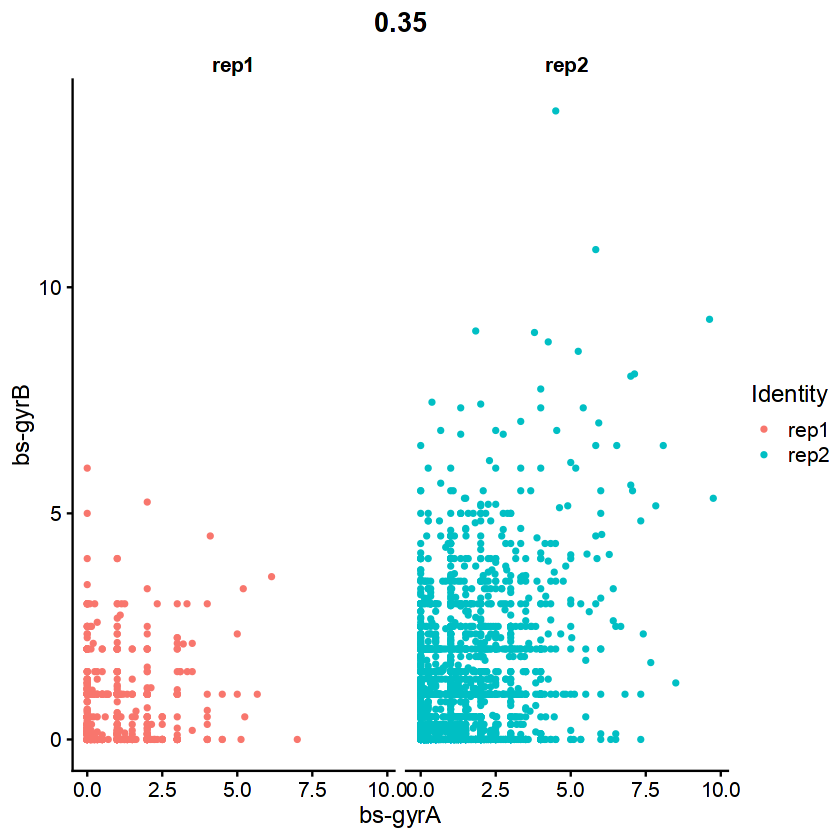

In [88]:
# For multiple gene pairs
FeatureScatter(
  object = seurat_obj_f2,       # Seurat object containing the data
  feature1 = c("bs-gyrA"),  # First genes in each pair
  feature2 = c( "bs-gyrB"),  # Second genes in each pair
  combine = FALSE  , # Combine into one multi-panel plot
  slot = "counts",   # Or "data", "scale.data", etc. based on what's available  
  group.by = "rep",  # Color by the "rep" metadata column                   
  split.by = "rep"   # Split by the "rep" metadata column
)

# Normalisation of data 


https://satijalab.org/seurat/reference/normalizedata

Normalize the count data present in a given assay.

NormalizeData(object, ...)

# S3 method for class 'V3Matrix'
NormalizeData(
  object,
  normalization.method = "LogNormalize",
  scale.factor = 10000,
  margin = 1,
  block.size = NULL,
  verbose = TRUE,
  ...
)

# S3 method for class 'Assay'
NormalizeData(
  object,
  normalization.method = "LogNormalize",
  scale.factor = 10000,
  margin = 1,
  verbose = TRUE,
  ...
)

# S3 method for class 'Seurat'
NormalizeData(
  object,
  assay = NULL,
  normalization.method = "LogNormalize",
  scale.factor = 10000,
  margin = 1,
  verbose = TRUE,
  ...
)
Arguments
object
An object

...
Arguments passed to other methods

normalization.method
Method for normalization.

“LogNormalize”: Feature counts for each cell are divided by the total counts for that cell and multiplied by the scale.factor. This is then natural-log transformed using log1p

“CLR”: Applies a centered log ratio transformation

“RC”: Relative counts. Feature counts for each cell are divided by the total counts for that cell and multiplied by the scale.factor. No log-transformation is applied. For counts per million (CPM) set scale.factor = 1e6

scale.factor
Sets the scale factor for cell-level normalization

margin
If performing CLR normalization, normalize across features (1) or cells (2)

block.size
How many cells should be run in each chunk, will try to split evenly across threads

verbose
display progress bar for normalization procedure

assay
Name of assay to use




🔍 Explication de scale.factor dans NormalizeData()

Le paramètre scale.factor détermine le facteur de mise à l’échelle utilisé lors de la normalisation des données au niveau des cellules.

⸻

📌 Comment ça fonctionne ?

Lorsque NormalizeData() est appliqué avec normalization.method = "LogNormalize" ou "RC", la normalisation se fait en trois étapes :

1️⃣ Calcul des proportions
	•	Chaque valeur de comptage (UMI ou read counts) dans une cellule est divisée par le total des comptes de cette cellule.
	•	Cela corrige les différences de profondeur de séquençage entre les cellules.

2️⃣ Mise à l’échelle avec scale.factor
	•	Les valeurs obtenues sont multipliées par scale.factor pour ajuster l’échelle des données.

3️⃣ (Optionnel) Transformation logarithmique (LogNormalize)
	•	Une transformation log1p (log(x + 1)) est appliquée pour réduire la variance des données.

⸻

💡 Exemple : scale.factor = 10000 (par défaut)

RNA_combined <- NormalizeData(RNA_combined, normalization.method = "LogNormalize", scale.factor = 10000)

✅ Signification :
	•	Pour chaque cellule, les comptages sont divisés par le total des comptes, puis multipliés par 10 000.
	•	Les valeurs normalisées sont ensuite log-transformées (log1p).

⸻

🔬 Effet de scale.factor sur les valeurs

scale.factor	Effet sur les données normalisées
1	Aucune mise à l’échelle, les valeurs restent entre 0 et 1.
10000 (par défaut)	Rend les valeurs comparables à une cellule avec 10 000 UMI.
1e6	Transforme les données en CPM (Counts Per Million).

Exemple avec scale.factor = 1e6 pour CPM

RNA_combined <- NormalizeData(RNA_combined, normalization.method = "RC", scale.factor = 1e6)

✅ Signification :
	•	Normalisation en CPM (Counts Per Million), une métrique souvent utilisée en transcriptomique.

⸻

🎯 Pourquoi utiliser scale.factor ?

✔ Corrige les différences de profondeur de séquençage 📊
✔ Ajuste l’échelle des valeurs normalisées 🔍
✔ Permet de comparer les cellules équitablement 🧬

Si tu as des questions, dis-moi ! 🚀

In [89]:
# Chargement du package Seurat
library(Seurat)

# Fonction NormalizeData
seurat_obj_f2 <- NormalizeData (object =seurat_obj_f2, 
                          normalization.method = "LogNormalize",  # Méthode de normalisation par défaut : les autres options sont "CLR" et "RC"
                          scale.factor = 10000,  # Facteur d'échelle pour la normalisation
                          margin = 1,  #If performing CLR normalization, normalize across features (1) or cells (2)
                          block.size = NULL,  # Taille des blocs pour traiter les cellules en parallèle
                          verbose = TRUE,  # Afficher une barre de progression
                          assay = NULL,  # Assay à normaliser (si NULL, utilise l'assay actif)
                        ) 


Normalizing layer: counts.1

Normalizing layer: counts.2



In [90]:
seurat_obj_f2

An object of class Seurat 
4422 features across 14961 samples within 1 assay 
Active assay: RNA (4422 features, 0 variable features)
 4 layers present: counts.1, counts.2, data.1, data.2

In [138]:
str (seurat_obj_f2)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 5
  .. .. .. .. ..$ counts.1  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:958633] 4 5 7 28 45 48 69 70 71 74 ...
  .. .. .. .. .. .. ..@ p       : int [1:2698] 0 317 1093 1629 2335 2561 3167 3920 4107 4604 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 4422 2697
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:958633] 1 1 0.65 0.65 2 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ counts.2  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:5594905] 1 5 6 7 8 9 23 24 27 28 ...
  .. .. .. .. .. .. ..@ p       : int [1:12265] 0 353 860 1061 1496 1792 2176 3009 3447 4441 ...
  

Dans Seurat v5, pour appliquer une normalisation basée sur la profondeur de lecture et conserver uniquement les 75 % des cellules ayant le plus de reads pour chaque densité optique (OD), voici la démarche générale :

⸻

📌 1. Charger les données et examiner la profondeur de lecture

library(Seurat)

# Charger l'objet Seurat
seurat_obj <- readRDS("mon_seurat_obj.rds")

# Vérifier la profondeur de lecture (nombre total d'UMIs par cellule)
seurat_obj$read_depth <- seurat_obj$nCount_RNA

# Si la variable OD est dans les métadonnées :
unique(seurat_obj$OD)  # Vérifier les niveaux d'OD



⸻

📌 2. Filtrer les cellules par quantile (top 75%) pour chaque OD

On applique un filtre dynamique en fonction des OD.

# Fonction pour filtrer les cellules du top 75% en read depth par OD
filter_top_cells <- function(seurat_obj, od_column = "OD", read_depth_column = "read_depth") {
  od_levels <- unique(seurat_obj[[od_column]])
  
  cells_to_keep <- c()
  
  for (od in od_levels) {
    subset_cells <- WhichCells(seurat_obj, expression = (get(od_column) == od))
    read_depths <- seurat_obj@meta.data[subset_cells, read_depth_column]
    
    # Calculer le seuil du 25e percentile (on garde les 75% supérieurs)
    threshold <- quantile(read_depths, probs = 0.25, na.rm = TRUE)
    
    # Sélectionner les cellules ayant un read_depth > seuil
    selected_cells <- subset_cells[read_depths > threshold]
    
    # Ajouter à la liste des cellules à conserver
    cells_to_keep <- c(cells_to_keep, selected_cells)
  }
  
  # Filtrer l'objet Seurat avec les cellules sélectionnées
  return(subset(seurat_obj, cells = cells_to_keep))
}

# Appliquer la filtration
seurat_obj_filtered <- filter_top_cells(seurat_obj)



⸻

📌 3. Vérification post-filtrage

# Vérifier le nombre de cellules restantes
table(seurat_obj_filtered$OD)

# Comparer avant/après
dim(seurat_obj)  # Nombre initial de cellules
dim(seurat_obj_filtered)  # Nombre de cellules après filtrage



⸻

🔥 Explication
	1.	On récupère les niveaux d’OD.
	2.	On filtre les cellules par OD :
	•	On sélectionne les cellules correspondant à un OD donné.
	•	On calcule le seuil du 25e percentile de la profondeur de lecture.
	•	On garde les cellules ayant un read depth supérieur à ce seuil.
	3.	On applique le filtre à l’objet Seurat.

⸻

💡 Alternatives :
	•	Si tu veux conserver un pourcentage différent (ex. 80 %), modifie probs = 0.20.
	•	Si la variable OD est factorielle, assure-toi qu’elle est bien définie dans seurat_obj@meta.data$OD.

Est-ce que cette approche correspond bien à ton besoin ? 😊

https://satijalab.org/seurat/reference/findvariablefeatures


FindVariableFeatures(object, ...)

# S3 method for class 'V3Matrix'
FindVariableFeatures(
  object,
  selection.method = "vst",
  loess.span = 0.3,
  clip.max = "auto",
  mean.function = FastExpMean,
  dispersion.function = FastLogVMR,
  num.bin = 20,
  binning.method = "equal_width",
  verbose = TRUE,
  ...
)

# S3 method for class 'Assay'
FindVariableFeatures(
  object,
  selection.method = "vst",
  loess.span = 0.3,
  clip.max = "auto",
  mean.function = FastExpMean,
  dispersion.function = FastLogVMR,
  num.bin = 20,
  binning.method = "equal_width",
  nfeatures = 2000,
  mean.cutoff = c(0.1, 8),
  dispersion.cutoff = c(1, Inf),
  verbose = TRUE,
  ...
)

# S3 method for class 'SCTAssay'
FindVariableFeatures(object, nfeatures = 2000, ...)

# S3 method for class 'Seurat'
FindVariableFeatures(
  object,
  assay = NULL,
  selection.method = "vst",
  loess.span = 0.3,
  clip.max = "auto",
  mean.function = FastExpMean,
  dispersion.function = FastLogVMR,
  num.bin = 20,
  binning.method = "equal_width",
  nfeatures = 2000,
  mean.cutoff = c(0.1, 8),
  dispersion.cutoff = c(1, Inf),
  verbose = TRUE,
  ...
)


Arguments
object
An object

...
Arguments passed to other methods

selection.method
How to choose top variable features. Choose one of :

“vst”: First, fits a line to the relationship of log(variance) and log(mean) using local polynomial regression (loess). Then standardizes the feature values using the observed mean and expected variance (given by the fitted line). Feature variance is then calculated on the standardized values after clipping to a maximum (see clip.max parameter).

“mean.var.plot” (mvp): First, uses a function to calculate average expression (mean.function) and dispersion (dispersion.function) for each feature. Next, divides features into num.bin (default 20) bins based on their average expression, and calculates z-scores for dispersion within each bin. The purpose of this is to identify variable features while controlling for the strong relationship between variability and average expression

“dispersion” (disp): selects the genes with the highest dispersion values

loess.span
(vst method) Loess span parameter used when fitting the variance-mean relationship

clip.max
(vst method) After standardization values larger than clip.max will be set to clip.max; default is 'auto' which sets this value to the square root of the number of cells

mean.function
Function to compute x-axis value (average expression). Default is to take the mean of the detected (i.e. non-zero) values

dispersion.function
Function to compute y-axis value (dispersion). Default is to take the standard deviation of all values

num.bin
Total number of bins to use in the scaled analysis (default is 20)

binning.method
Specifies how the bins should be computed. Available methods are:

“equal_width”: each bin is of equal width along the x-axis (default)

“equal_frequency”: each bin contains an equal number of features (can increase statistical power to detect overdispersed features at high expression values, at the cost of reduced resolution along the x-axis)

verbose
show progress bar for calculations

nfeatures
Number of features to select as top variable features; only used when selection.method is set to 'dispersion' or 'vst'

mean.cutoff
A two-length numeric vector with low- and high-cutoffs for feature means

dispersion.cutoff
A two-length numeric vector with low- and high-cutoffs for feature dispersions

assay
Assay to use

🔍 Explication détaillée de FindVariableFeatures()

La fonction FindVariableFeatures() dans Seurat permet d’identifier les gènes les plus variables dans un jeu de données single-cell RNA-seq.
Ces gènes hautement variables sont importants car ils portent l’essentiel de l’information biologique et permettent d’améliorer le clustering et la réduction de dimensionnalité (PCA, UMAP).

⸻

📌 Fonction avec commentaires en français

FindVariableFeatures(
  object,                      # Objet Seurat contenant les données single-cell
  assay = NULL,                # Nom de l’assay à utiliser (par défaut, assay actif)
  selection.method = "vst",    # Méthode de sélection des gènes variables ("vst", "mvp", "disp")
  loess.span = 0.3,            # Paramètre de lissage LOESS (méthode "vst")
  clip.max = "auto",           # Valeur max après normalisation (limite la variance extrême)
  mean.function = FastExpMean, # Fonction pour calculer l’expression moyenne des gènes
  dispersion.function = FastLogVMR, # Fonction pour calculer la dispersion (variabilité) des gènes
  num.bin = 20,                # Nombre de classes (bins) pour standardiser les dispersions
  binning.method = "equal_width", # Méthode de binning : "equal_width" ou "equal_frequency"
  nfeatures = 2000,            # Nombre de gènes à conserver comme hautement variables
  mean.cutoff = c(0.1, 8),     # Seuils bas et hauts pour la moyenne d’expression des gènes
  dispersion.cutoff = c(1, Inf), # Seuils bas et hauts pour la dispersion des gènes
  verbose = TRUE,              # Affiche la progression de l’analyse
  ...
)



⸻

📌 Explication des principaux paramètres

1️⃣ Méthodes de sélection des gènes variables (selection.method)

Méthode	Explication
"vst" (par défaut)	Modèle statistique basé sur la variance et la moyenne des gènes. Utilise un lissage LOESS pour corriger la relation moyenne-variance. Très utilisé en scRNA-seq.
"mean.var.plot" ("mvp")	Bins les gènes en fonction de leur moyenne et applique un score Z pour détecter les gènes variables.
"dispersion" ("disp")	Sélectionne les gènes avec la plus grande dispersion absolue.

📌 Recommandation :
	•	"vst" est la méthode la plus robuste pour identifier les gènes variables en scRNA-seq.
	•	"mvp" et "disp" peuvent être utiles pour des données atypiques.

⸻

2️⃣ Paramètres spécifiques aux méthodes
	•	loess.span (Seulement pour "vst")
	•	Définit le degré de lissage appliqué lors du modèle de variance-moyenne.
	•	Valeur plus faible = moins de lissage, valeur plus élevée = plus de lissage.
	•	clip.max (Seulement pour "vst")
	•	Valeur maximale autorisée après la standardisation.
	•	Par défaut "auto" = √(nombre de cellules).
	•	Permet de limiter l’influence des gènes extrêmes.

⸻

3️⃣ Gestion des bins (num.bin, binning.method)
	•	num.bin = 20 (par défaut)
	•	Divise les gènes en 20 groupes basés sur leur expression moyenne.
	•	Utilisé pour standardiser la dispersion et comparer des gènes similaires.
	•	binning.method
	•	"equal_width" (par défaut) : chaque bin couvre une même plage d’expression.
	•	"equal_frequency" : chaque bin a le même nombre de gènes.
	•	"equal_frequency" est utile pour favoriser les gènes très exprimés, mais réduit la résolution sur les gènes faiblement exprimés.

⸻

4️⃣ Sélection des gènes (nfeatures, mean.cutoff, dispersion.cutoff)
	•	nfeatures = 2000
	•	Nombre de gènes à retenir comme les plus variables.
	•	En général, 2000 gènes suffisent pour une analyse standard.
	•	mean.cutoff = c(0.1, 8)
	•	Exclut les gènes trop faiblement ou trop fortement exprimés.
	•	Ici, seuls les gènes ayant une moyenne entre 0.1 et 8 UMI sont conservés.
	•	dispersion.cutoff = c(1, Inf)
	•	Seuils pour la dispersion (variation du gène entre cellules).
	•	Ici, seuls les gènes ayant une dispersion > 1 sont conservés.

⸻

📌 Exemples d’utilisation

1️⃣ Sélection des gènes variables (méthode standard)

RNA_combined <- FindVariableFeatures(RNA_combined)

➡️ Utilise "vst" par défaut avec 2000 gènes les plus variables.

⸻

2️⃣ Modifier le nombre de gènes retenus

RNA_combined <- FindVariableFeatures(RNA_combined, nfeatures = 3000)

➡️ Conserve 3000 gènes les plus variables au lieu de 2000.

⸻

3️⃣ Utiliser la méthode "dispersion"

RNA_combined <- FindVariableFeatures(RNA_combined, selection.method = "dispersion")

➡️ Choisit les gènes avec la plus grande dispersion absolue.

⸻

4️⃣ Ajuster les seuils de sélection

RNA_combined <- FindVariableFeatures(RNA_combined, 
                                     mean.cutoff = c(0.2, 5), 
                                     dispersion.cutoff = c(0.5, Inf))

➡️ Ne garde que les gènes avec une moyenne entre 0.2 et 5 UMI, et une dispersion > 0.5.

⸻

🔬 Pourquoi FindVariableFeatures() est important ?

✅ Filtrer les gènes informatifs : En scRNA-seq, tous les gènes ne sont pas biologiquement pertinents (ex. gènes constitutifs).
✅ Améliorer le clustering : Les gènes les plus variables sont les plus informatifs pour identifier les sous-populations cellulaires.
✅ Optimiser la réduction de dimension (PCA, UMAP) : Sélectionner les bonnes features améliore la qualité des projections.

⸻

🚀 Résumé

Paramètre	Effet
selection.method = "vst"	Modèle robuste basé sur la variance et la moyenne (par défaut).
nfeatures = 2000	Nombre de gènes les plus variables à retenir.
mean.cutoff = c(0.1, 8)	Exclut les gènes trop peu ou trop fortement exprimés.
dispersion.cutoff = c(1, Inf)	Exclut les gènes avec trop peu de variation.
binning.method = "equal_width"	Coupe l’expression en classes de même largeur.
verbose = TRUE	Affiche une barre de progression.



⸻

💡 Conseil : Utilise vst avec 2000 gènes pour une analyse standard.
Si tu veux plus de précision ou si tes données sont atypiques, ajuste les paramètres ! 🚀

🔍 Explication des méthodes de sélection des gènes variables dans FindVariableFeatures()

La fonction FindVariableFeatures() propose trois méthodes principales pour identifier les gènes les plus variables, qui sont essentiels pour l’analyse de scRNA-seq.

Méthode	Avantages	Inconvénients	Utilisation recommandée
"vst" (Variance Stabilizing Transformation)	Méthode robuste basée sur un modèle statistique de variance et moyenne.	Peut être biaisé par certains artefacts techniques.	⚡ Recommandé par défaut pour scRNA-seq.
"mean.var.plot" (MVP)	Sélectionne les gènes variables en tenant compte de l’expression moyenne via une standardisation par bins.	Moins précis que "vst" pour de grands jeux de données.	Utile pour les petits jeux de données.
"dispersion" (Dispersion brute)	Sélectionne simplement les gènes avec la plus grande variance absolue.	Ne tient pas compte de l’expression moyenne, ce qui peut biaiser la sélection.	Peut être utile pour données atypiques.



⸻

📌 Détail des méthodes

1️⃣ vst : Variance Stabilizing Transformation (⚡ Méthode recommandée)

Principe :
✅ Modélise la relation entre la variance et la moyenne des gènes.
✅ Applique un lissage LOESS pour corriger cette relation.
✅ Standardise les valeurs en écart-type (z-score) pour identifier les gènes les plus variables.

RNA_combined <- FindVariableFeatures(RNA_combined, selection.method = "vst")

✅ Pourquoi l’utiliser ?
	•	Méthode robuste et fiable pour scRNA-seq.
	•	Corrige l’effet de la moyenne sur la variance (sinon, les gènes très exprimés paraîtraient toujours les plus variables).
	•	Recommandé pour la plupart des analyses.

⸻

2️⃣ mean.var.plot (MVP) : Standardisation dans des bins d’expression

Principe :
✅ Classe les gènes en bins (catégories) selon leur moyenne d’expression.
✅ Calcule un z-score de la dispersion à l’intérieur de chaque bin.
✅ Sélectionne les gènes ayant une dispersion anormalement élevée dans leur bin.

RNA_combined <- FindVariableFeatures(RNA_combined, selection.method = "mean.var.plot")

✅ Pourquoi l’utiliser ?
	•	Utile pour les petits jeux de données car il contrôle la variabilité.
	•	Permet d’éviter que seuls les gènes très exprimés soient sélectionnés.
	•	Moins robuste que "vst" pour les grands jeux de données.

⸻

3️⃣ dispersion : Sélection basée uniquement sur la variance absolue

Principe :
✅ Calcule la dispersion brute des gènes.
✅ Sélectionne les gènes avec la variance la plus élevée, sans tenir compte de leur niveau d’expression moyen.

RNA_combined <- FindVariableFeatures(RNA_combined, selection.method = "dispersion")

✅ Pourquoi l’utiliser ?
	•	Méthode très simple et rapide.
	•	Peut être utile si les données sont très bruitées et que "vst" ne fonctionne pas bien.
	•	Mais risque de privilégier les gènes les plus exprimés, même si leur variation est peu informative.

⸻

🎯 Quelle méthode choisir ?

Cas	Méthode recommandée
Données classiques en scRNA-seq	"vst" ✅
Petit nombre de cellules (<1000)	"mean.var.plot"
Données atypiques, bruitées	"dispersion" (peut être testé)

✅ Dans la majorité des cas, "vst" est la meilleure option car elle corrige l’effet de la moyenne et sélectionne les gènes les plus informatifs de manière robuste.

Si tu veux plus d’explications ou un test sur tes données, dis-moi ! 🚀

# Mise à l'échelle des données
Ensuite, nous appliquons une transformation linéaire (« mise à l'échelle »), étape de prétraitement standard avant les techniques de réduction dimensionnelle comme l'ACP. La ScaleData()fonction :

Décale l'expression de chaque gène, de sorte que l'expression moyenne à travers les cellules soit de 0
Met à l'échelle l'expression de chaque gène, de sorte que la variance entre les cellules soit de 1
Cette étape donne un poids égal dans les analyses en aval, de sorte que les gènes hautement exprimés ne dominent pas
Les résultats de cette opération sont stockés danspbmc[["RNA"]]$scale.data
Par défaut, seules les fonctionnalités variables sont mises à l'échelle.
Vous pouvez spécifier l' featuresargument pour mettre à l'échelle des fonctionnalités supplémentaires
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)



In [100]:
seurat_obj_f2 <- FindVariableFeatures(object = seurat_obj_f2, 
                                  selection.method = "vst" # Méthode de sélection des gènes variables : "vst" (par défaut), "mean.var.plot", "dispersion", "pca" ou "none"
)

Finding variable features for layer counts.1

Finding variable features for layer counts.2



https://satijalab.org/seurat/reference/variablefeatureplot

VariableFeaturePlot(
  object,
  cols = c("black", "red"),
  pt.size = 1,
  log = NULL,
  selection.method = NULL,
  assay = NULL,
  raster = NULL,
  raster.dpi = c(512, 512)
)

Arguments
object
Seurat object

cols
Colors to specify non-variable/variable status

pt.size
Size of the points on the plot

log
Plot the x-axis in log scale


assay
Assay to pull variable features from

raster
Convert points to raster format, default is NULL which will automatically use raster if the number of points plotted is greater than 100,000

raster.dpi
Pixel resolution for rasterized plots, passed to geom_scattermore(). Default is c(512, 512).



[1] "bs-ganB" "bs-licH" "bs-xepA" "bs-nusG" "bs-trpC" "bs-licC" "bs-xhlA"
 [8] "bs-xhlB" "bs-splB" "bs-licA"

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


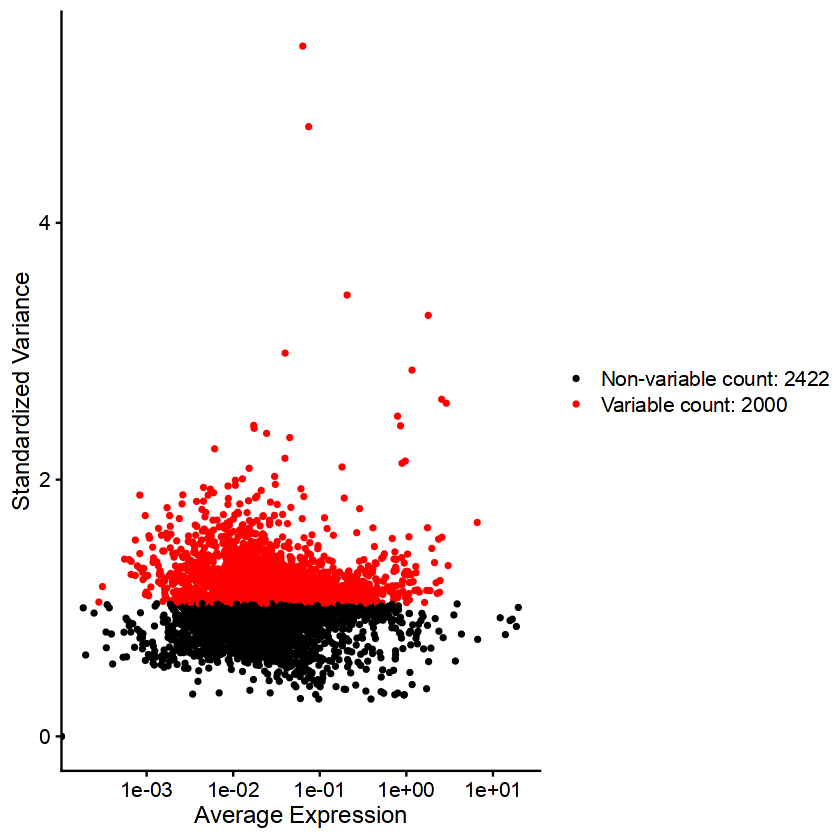

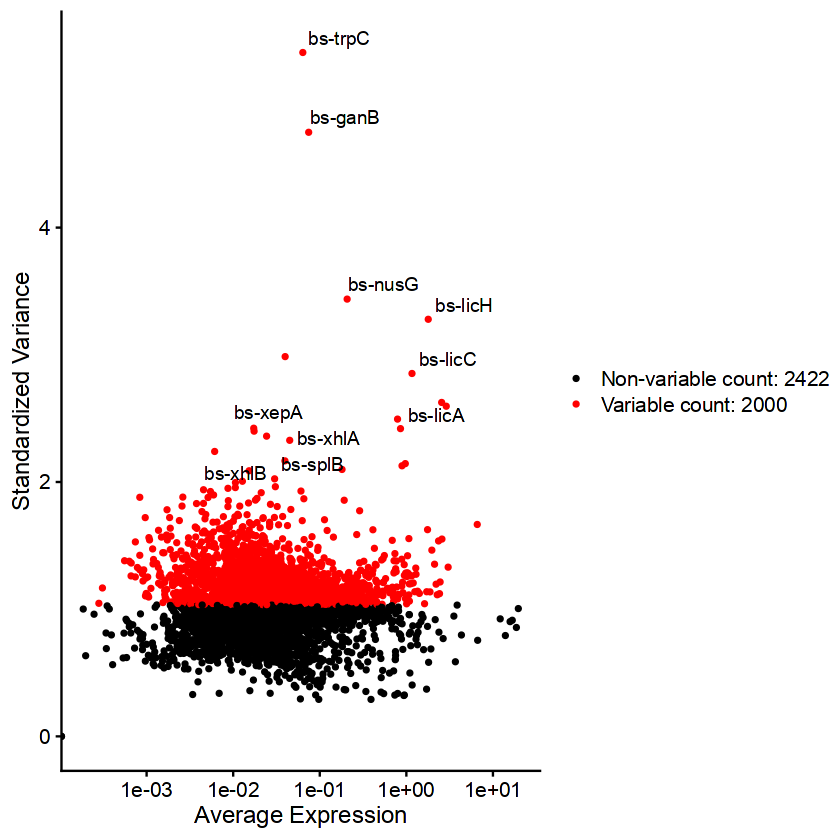

In [142]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat_obj_f2), 10)
top10
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(seurat_obj_f2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 
plot2

In [101]:
head (seurat_obj_f2)

,nCount_RNA,nFeature_RNA,rep,sublibrary,well,cond
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
rep1_AACAACCA_CCGACAAC_ACTCGTAA,393.5870,317,rep1,M15,A1,OD0.5
rep1_AACCGAGA_GTGTTCTA_ACTCGTAA,1464.6578,776,rep1,M15,A1,OD0.5
rep1_AACTCACC_GTACGCAA_ACTCGTAA,897.9934,536,rep1,M15,A1,OD0.5
rep1_AAGGACAC_GAGTTAGC_ACTCGTAA,1124.2410,706,rep1,M15,A1,OD0.5
rep1_AATCCGTC_GCTAACGA_ACTCGTAA,297.7506,226,rep1,M15,A1,OD0.5
rep1_ACAAGCTA_CTAAGGTC_ACTCGTAA,917.4909,606,rep1,M15,A1,OD0.5
rep1_ACCTCCAA_CACTTCGA_ACTCGTAA,1495.7515,753,rep1,M15,A1,OD0.5
rep1_ACGTATCA_AGCAGGAA_ACTCGTAA,234.1950,187,rep1,M15,A1,OD0.5
rep1_ACTATGCA_GAACAGGC_ACTCGTAA,659.8654,497,rep1,M15,A1,OD0.5


https://satijalab.org/seurat/reference/scaledata

ScaleData(object, ...)

# Default S3 method
ScaleData(
  object,
  features = NULL,
  vars.to.regress = NULL,
  latent.data = NULL,
  split.by = NULL,
  model.use = "linear",
  use.umi = FALSE,
  do.scale = TRUE,
  do.center = TRUE,
  scale.max = 10,
  block.size = 1000,
  min.cells.to.block = 3000,
  verbose = TRUE,
  ...
)

# S3 method for class 'IterableMatrix'
ScaleData(
  object,
  features = NULL,
  do.scale = TRUE,
  do.center = TRUE,
  scale.max = 10,
  ...
)

# S3 method for class 'Assay'
ScaleData(
  object,
  features = NULL,
  vars.to.regress = NULL,
  latent.data = NULL,
  split.by = NULL,
  model.use = "linear",
  use.umi = FALSE,
  do.scale = TRUE,
  do.center = TRUE,
  scale.max = 10,
  block.size = 1000,
  min.cells.to.block = 3000,
  verbose = TRUE,
  ...
)

# S3 method for class 'Seurat'
ScaleData(
  object,
  features = NULL,
  assay = NULL,
  vars.to.regress = NULL,
  split.by = NULL,
  model.use = "linear",
  use.umi = FALSE,
  do.scale = TRUE,
  do.center = TRUE,
  scale.max = 10,
  block.size = 1000,
  min.cells.to.block = 3000,
  verbose = TRUE,
  ...
)Scales and centers features in the dataset. If variables are provided in vars.to.regress, they are individually regressed against each feature, and the resulting residuals are then scaled and centered. Arguments
object
An object

...
Arguments passed to other methods

features
Vector of features names to scale/center. Default is variable features.

vars.to.regress
Variables to regress out (previously latent.vars in RegressOut). For example, nUMI, or percent.mito.

latent.data
Extra data to regress out, should be cells x latent data

split.by
Name of variable in object metadata or a vector or factor defining grouping of cells. See argument f in split for more details

model.use
Use a linear model or generalized linear model (poisson, negative binomial) for the regression. Options are 'linear' (default), 'poisson', and 'negbinom'

use.umi
Regress on UMI count data. Default is FALSE for linear modeling, but automatically set to TRUE if model.use is 'negbinom' or 'poisson'

do.scale
Whether to scale the data.

do.center
Whether to center the data.

scale.max
Max value to return for scaled data. The default is 10. Setting this can help reduce the effects of features that are only expressed in a very small number of cells. If regressing out latent variables and using a non-linear model, the default is 50.

block.size
Default size for number of features to scale at in a single computation. Increasing block.size may speed up calculations but at an additional memory cost.

min.cells.to.block
If object contains fewer than this number of cells, don't block for scaling calculations.

verbose
Displays a progress bar for scaling procedure

assay
Name of Assay to scale

Details
ScaleData now incorporates the functionality of the function formerly known as RegressOut (which regressed out given the effects of provided variables and then scaled the residuals). To make use of the regression functionality, simply pass the variables you want to remove to the vars.to.regress parameter.

Setting center to TRUE will center the expression for each feature by subtracting the average expression for that feature. Setting scale to TRUE will scale the expression level for each feature by dividing the centered feature expression levels by their standard deviations if center is TRUE and by their root mean square otherwise. explique et commente cette fonction seurat

🔍 Explication détaillée de ScaleData() dans Seurat

La fonction ScaleData() est utilisée pour centrer et normaliser les données d’expression des gènes dans un objet Seurat.
Elle permet aussi de régresser des variables indésirables (ex. effet du nombre d’UMIs ou pourcentage de gènes mitochondriaux) avant de scaler les données.

⸻

📌 Fonction avec commentaires en français

ScaleData(
  object,                  # Objet Seurat contenant les données à scaler
  features = NULL,         # Liste des gènes à normaliser (par défaut : gènes les plus variables)
  vars.to.regress = NULL,  # Variables à régresser avant la normalisation (ex: "nCount_RNA", "percent.mt")
  latent.data = NULL,      # Données supplémentaires à régresser (matrice cellules x variables)
  split.by = NULL,         # Séparer le scaling en plusieurs groupes basés sur une métadonnée
  model.use = "linear",    # Type de modèle pour la régression ("linear", "poisson", "negbinom")
  use.umi = FALSE,         # Régresser directement sur les UMI ? (utile pour "poisson" et "negbinom")
  do.scale = TRUE,         # Appliquer une mise à l’échelle ? (diviser par l’écart-type)
  do.center = TRUE,        # Centrer les données ? (soustraire la moyenne)
  scale.max = 10,          # Valeur max autorisée après scaling (évite l’influence des gènes rares)
  block.size = 1000,       # Nombre de features traitées par batch (augmente vitesse mais consomme mémoire)
  min.cells.to.block = 3000, # Si moins de 3000 cellules, ne pas utiliser de blocking
  verbose = TRUE,          # Affiche une barre de progression
  assay = NULL,            # Assay à utiliser (par défaut : actif)
  ...
)



⸻

📌 Explication des paramètres principaux

1️⃣ Centrage et Scaling (do.center, do.scale, scale.max)

Paramètre	Effet
do.center = TRUE	Centre l’expression des gènes en soustrayant la moyenne de chaque gène.
do.scale = TRUE	Normalise en divisant chaque gène par son écart-type.
scale.max = 10	Coupe les valeurs extrêmes pour éviter qu’un gène rare domine l’analyse.

✅ Par défaut, ScaleData() applique ces deux transformations.
Cela garantit que les données sont comparables entre les gènes et les cellules.

⸻

2️⃣ Régression des effets indésirables (vars.to.regress)

Seurat permet de retirer des effets de batch ou des biais techniques en régressant certaines variables avant le scaling.

RNA_combined <- ScaleData(RNA_combined, vars.to.regress = c("nCount_RNA", "percent.mt"))

✅ Ici, ScaleData() :
	1.	Régresse nCount_RNA (profondeur de séquençage) et percent.mt (proportion de gènes mitochondriaux).
	2.	Transforme les résidus obtenus pour enlever l’effet de ces variables.
	3.	Centre et normalise ces nouvelles valeurs.

⸻

3️⃣ Modèles statistiques utilisés (model.use)

Par défaut, ScaleData() utilise un modèle linéaire (lm) pour la régression.
Mais d’autres modèles sont possibles si les données suivent une distribution spécifique :

Modèle	Description
"linear"	Régression linéaire classique (par défaut).
"poisson"	Régression Poisson, adaptée aux données UMI brutes.
"negbinom"	Modèle binomial négatif, utilisé pour des données fortement bruitées.

Si tu travailles avec des UMI bruts, il est recommandé de changer model.use et activer use.umi = TRUE :

RNA_combined <- ScaleData(RNA_combined, vars.to.regress = "nCount_RNA", model.use = "negbinom", use.umi = TRUE)

✅ Ici, Seurat applique un modèle binomial négatif qui prend mieux en compte les distributions de comptage UMI.

⸻

4️⃣ Scaling par groupes (split.by)

Si ton dataset contient des batches ou des conditions expérimentales, split.by permet d’appliquer ScaleData() séparément sur chaque groupe.

RNA_combined <- ScaleData(RNA_combined, split.by = "batch")

✅ Cela permet d’éviter que les différences de scaling entre les batches n’affectent l’analyse.

⸻

5️⃣ Gestion des performances (block.size, min.cells.to.block)

Si ton dataset est très grand, ScaleData() découpe les gènes en batches pour accélérer les calculs.

Paramètre	Effet
block.size = 1000	Par défaut, 1000 gènes sont traités en parallèle. Augmenter cette valeur accélère le scaling mais consomme plus de mémoire.
min.cells.to.block = 3000	Si le dataset contient moins de 3000 cellules, pas de blocking est appliqué.



⸻

📌 Exemples d’utilisation

1️⃣ Scaling standard (centrage et normalisation)

RNA_combined <- ScaleData(RNA_combined)

✅ Centre et normalise les données sur les gènes les plus variables.

⸻

2️⃣ Régression du nombre d’UMIs et des gènes mitochondriaux

RNA_combined <- ScaleData(RNA_combined, vars.to.regress = c("nCount_RNA", "percent.mt"))

✅ Supprime l’effet de la profondeur de séquençage avant normalisation.

⸻

3️⃣ Scaling par batch

RNA_combined <- ScaleData(RNA_combined, split.by = "batch")

✅ Applique ScaleData() séparément à chaque batch expérimental.

⸻

4️⃣ Scaling avec régression Poisson (si UMI bruts)

RNA_combined <- ScaleData(RNA_combined, vars.to.regress = "nCount_RNA", model.use = "poisson", use.umi = TRUE)

✅ Utilise un modèle Poisson pour la régression, recommandé pour les données brutes (non transformées).

⸻

🎯 Pourquoi utiliser ScaleData() ?

✔ Standardise les données : Centrage + Scaling garantissent que tous les gènes sont comparables.
✔ Corrige les effets techniques : vars.to.regress permet d’éliminer les biais dus à la profondeur de séquençage.
✔ Améliore les analyses de clustering et PCA : Empêche que l’expression brute (souvent biaisée) n’influence trop les résultats.

🚀 En résumé :

Objectif	Commande
Normalisation standard	ScaleData(RNA_combined)
Retirer effet du nombre d’UMIs	ScaleData(RNA_combined, vars.to.regress = "nCount_RNA")
Normaliser par batch	ScaleData(RNA_combined, split.by = "batch")
Régression Poisson sur UMI bruts	ScaleData(RNA_combined, model.use = "poisson", use.umi = TRUE)



⸻

🔬 Conclusion
	•	ScaleData() est une étape clé après FindVariableFeatures() pour préparer les données avant PCA, clustering, et UMAP.
	•	Par défaut (do.center = TRUE, do.scale = TRUE), elle applique un centrage et une normalisation sur les gènes variables.
	•	Elle permet aussi d’éliminer des effets non désirés (ex. batch effect, nUMI, % mitochondrial) via vars.to.regress.

💡 Toujours appliquer ScaleData() avant l’analyse de PCA et clustering pour de meilleurs résultats ! 🚀

🔍 Comment savoir si je travaille avec des UMI bruts en scRNA-seq ?

Les UMI (Unique Molecular Identifiers) sont des codes barres uniques ajoutés aux molécules d’ARN avant l’amplification pour éviter les biais liés à la PCR.
Si ton jeu de données est issu d’une technologie scRNA-seq basée sur les UMI (ex. 10x Genomics, Drop-seq, etc.), alors les comptages sont en UMI.

⸻

📌 Vérifier si tes données contiennent des UMI

1️⃣ Regarder la source des données
	•	Si tes données viennent d’une technologie comme 10x Genomics, Drop-seq, CEL-Seq, alors elles utilisent des UMI.
	•	Si tes données viennent d’une technologie comme Smart-seq2, alors elles ne contiennent pas d’UMI (car Smart-seq2 capture des fragments ARN complets).

2️⃣ Vérifier l’objet Seurat (RNA_combined)
Dans Seurat, les UMI sont souvent stockés dans l’assay "RNA" dans le slot "counts".
Tu peux vérifier les comptages bruts comme ceci :

head(RNA_combined@assays$RNA@counts)

📌 Si les valeurs sont des nombres entiers, c’est probablement des UMI.

3️⃣ Vérifier le nombre total de comptes (nCount_RNA)
Les UMI sont comptés cellule par cellule :

summary(RNA_combined$nCount_RNA)

📌 Si les valeurs sont élevées (ex. > 1000 par cellule), alors c’est souvent un dataset basé sur des UMI.

4️⃣ Regarder la documentation des données
Si tu utilises un dataset public, la documentation ou l’article associé précise si les données sont en UMI ou en read counts.

⸻

📌 Pourquoi use.umi = TRUE est important avec des UMI ?

Quand tu utilises ScaleData() avec model.use = "poisson" ou "negbinom", Seurat ajuste correctement la régression aux données UMI-based.

RNA_combined <- ScaleData(RNA_combined, vars.to.regress = "nCount_RNA", model.use = "poisson", use.umi = TRUE)

✅ Pourquoi ?
	•	Les UMI suivent une distribution Poissonienne plutôt qu’une distribution normale.
	•	Les méthodes linéaires classiques ne sont pas optimales pour traiter ces données.
	•	Avec use.umi = TRUE, Seurat ajuste la modélisation statistique pour les UMI.

💡 Si tu travailles avec des UMI, active use.umi = TRUE pour de meilleures corrections ! 🚀

🔍 Split-seq utilise-t-il des UMI ?

Oui ! Split-seq est une technologie scRNA-seq basée sur des UMI. Elle utilise un marquage combinatoire par barcoding séquentiel pour identifier chaque cellule.
Tes comptages dans l’objet Seurat sont donc des UMI bruts, et il est recommandé d’utiliser use.umi = TRUE avec ScaleData() si tu appliques une régression.

⸻

📌 Comment appliquer ScaleData() correctement avec Split-seq ?

Comme Split-seq génère des comptages UMI, il est préférable d’utiliser un modèle Poisson ou binomial négatif plutôt qu’un modèle linéaire classique.

RNA_combined <- ScaleData(RNA_combined, 
                          vars.to.regress = "nCount_RNA", 
                          model.use = "poisson", 
                          use.umi = TRUE)

✅ Pourquoi ?
	•	Les UMI suivent une distribution de comptage (Poisson ou binomiale négative).
	•	Le modèle linéaire classique (lm) n’est pas optimal pour ce type de données.
	•	Le modèle Poisson (poisson) ou binomial négatif (negbinom) ajuste mieux la variabilité des comptages UMI.

⸻

📌 À retenir pour Split-seq

✔ Les données sont en UMI → utiliser use.umi = TRUE.
✔ Les UMI suivent une distribution de comptage → utiliser model.use = "poisson" ou "negbinom".
✔ Corriger les biais techniques → vars.to.regress = "nCount_RNA".

Tu peux tester et voir l’impact sur tes résultats ! 🚀

🔍 Pourquoi régressons-nous nCount_RNA dans ScaleData() ?

En scRNA-seq, le nombre total de comptages UMI par cellule (nCount_RNA) varie d’une cellule à l’autre.
Cette variation est due à des facteurs techniques plutôt qu’à des différences biologiques réelles.
La régression de nCount_RNA permet de supprimer ces effets techniques pour que l’analyse soit plus fiable.

⸻

📌 Problème : L’effet du nombre d’UMIs sur l’expression des gènes
	•	Dans un dataset scRNA-seq basé sur les UMI (comme Split-seq), certaines cellules capturent plus d’ARNs simplement parce qu’elles ont été mieux séquencées.
	•	Sans correction, les cellules avec un nombre élevé d’UMIs auront l’air d’avoir une expression génique plus forte, même si ce n’est pas un effet biologique réel.

🔹 Exemple d’effet technique non corrigé :

Cellule	nCount_RNA	Expression brute d’un gène (GENE_X)
Cellule A	500	10
Cellule B	5000	100

👉 Sans correction, on pourrait croire que GENE_X est 10 fois plus exprimé dans la cellule B.
👉 En réalité, c’est juste parce que cette cellule a été mieux séquencée !

⸻

📌 Solution : Régresser nCount_RNA avec ScaleData()

RNA_combined <- ScaleData(RNA_combined, vars.to.regress = "nCount_RNA", model.use = "poisson", use.umi = TRUE)

✅ Ce que fait cette régression :
	1.	Modèle statistique : Ajuste chaque gène en fonction du nombre total d’UMIs (nCount_RNA).
	2.	Élimine l’effet technique : Corrige l’impact du séquençage sur l’expression génique.
	3.	Retourne les résidus de la régression : Permet d’analyser uniquement les variations biologiques réelles.

⸻

📌 Quand faut-il régressons nCount_RNA ?

✔ Toujours recommandé pour les données scRNA-seq à base d’UMI (comme Split-seq, 10x Genomics).
✔ Si la variation de nCount_RNA est importante dans ton dataset (vérifiable avec summary(RNA_combined$nCount_RNA)).
✔ Avant un clustering ou une PCA, pour éviter un biais dû à la profondeur de séquençage.

⸻

📌 Conclusion : Pourquoi régresser nCount_RNA ?

✔ Évite les biais liés à la profondeur de séquençage.
✔ Assure que l’expression des gènes reflète une vraie biologie.
✔ Améliore la qualité du clustering et de l’analyse de dimensionnalité (PCA, UMAP).

💡 Avec Split-seq (qui utilise des UMI), toujours penser à régresser nCount_RNA pour obtenir des résultats plus fiables ! 🚀


Comment puis-je supprimer les sources de variation indésirables
Dans Seurat, nous utilisons également cette ScaleData()fonction pour supprimer les sources de variation indésirables d'un ensemble de données unicellulaires. Par exemple, nous pourrions éliminer par régression l'hétérogénéité associée, par exemple, au stade du cycle cellulaire ou à la contamination mitochondriale, c'est-à-dire :

pbmc <- ScaleData(pbmc, vars.to.regress = "percent.mt")
Cependant, en particulier pour les utilisateurs avancés qui souhaiteraient utiliser cette fonctionnalité, nous recommandons fortement l'utilisation de notre nouveau flux de travail de normalisation, SCTransform(). La méthode est décrite dans notre article , avec une vignette séparée utilisant Seurat ici . Comme avec ScaleData(), la fonction SCTransform()comprend également un vars.to.regressparamètre.


# Important : plutot utiliser SCtransform pour eliminer certain probleme 

https://satijalab.org/seurat/articles/sctransform_vignette


https://sib-swiss.github.io/single-cell-training/day1/day1-3_normalization_scaling.html






all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

ScaleData(
  object,                  # Objet Seurat contenant les données à scaler
  features = NULL,         # Liste des gènes à normaliser (par défaut : gènes les plus variables)
  vars.to.regress = NULL,  # Variables à régresser avant la normalisation (ex: "nCount_RNA", "percent.mt")
  latent.data = NULL,      # Données supplémentaires à régresser (matrice cellules x variables)
  split.by = NULL,         # Séparer le scaling en plusieurs groupes basés sur une métadonnée
  model.use = "linear",    # Type de modèle pour la régression ("linear", "poisson", "negbinom")
  use.umi = FALSE,         # Régresser directement sur les UMI ? (utile pour "poisson" et "negbinom")
  do.scale = TRUE,         # Appliquer une mise à l’échelle ? (diviser par l’écart-type)
  do.center = TRUE,        # Centrer les données ? (soustraire la moyenne)
  scale.max = 10,          # Valeur max autorisée après scaling (évite l’influence des gènes rares)
  block.size = 1000,       # Nombre de features traitées par batch (augmente vitesse mais consomme mémoire)
  min.cells.to.block = 3000, # Si moins de 3000 cellules, ne pas utiliser de blocking
  verbose = TRUE,          # Affiche une barre de progression
  assay = NULL,            # Assay à utiliser (par défaut : actif)
  ...
)

Dans le cadre de ton analyse scRNA-seq microSplit, voici quelques recommandations pour l’utilisation de ScaleData() dans Seurat :

Paramètres clés à adapter pour microSplit
	1.	object : Ton objet Seurat contenant tes données scRNA-seq microSplit.
	2.	features : Mets ici les gènes que tu veux normaliser. En général, ce sont les gènes les plus variables (HVGs) sélectionnés après FindVariableFeatures().
	3.	vars.to.regress :
	•	Pour enlever l’effet du nombre total d’UMI par cellule → "nCount_RNA"
	•	Si tu veux corriger l’effet des mitochondries (selon ton type d’échantillon) → "percent.mt"
	•	Si tu as une covariable expérimentale importante (ex. batch) → Ajoute la métadonnée correspondante.
	4.	split.by :
	•	Si tes échantillons ont des conditions distinctes et que tu veux normaliser séparément → mets une métadonnée pertinente ("condition", "batch", "replicate", etc.).
	•	Dans microSplit, si tes cellules sont multiplexées par un barcode spécifique, tu peux vérifier si un splitting par barcode est nécessaire.
	5.	model.use :
	•	"linear" est suffisant dans la plupart des cas.
	•	Si tes données suivent une distribution de comptage (ex. UMI-based data), "poisson" ou "negbinom" peuvent être envisagés, mais rarement nécessaires après NormalizeData().
	6.	use.umi :
	•	Mets TRUE si tu utilises "poisson" ou "negbinom".
	7.	do.scale & do.center :
	•	Laisse TRUE pour standardiser correctement les valeurs.
	8.	scale.max :
	•	10 par défaut fonctionne bien, mais si tu observes des valeurs extrêmes, essaie 5.
	9.	block.size & min.cells.to.block :
	•	Par défaut, ces paramètres sont adaptés aux gros jeux de données. À ajuster si tu rencontres des problèmes de mémoire.
	10.	assay :
	•	Mets "RNA" si tu travailles sur l’assay de base, sinon choisis l’assay correspondant (ex. "integrated" après une intégration multi-sample).

⸻

Exemple de commande adaptée à microSplit

pbmc <- ScaleData(
  object = pbmc, 
  features = VariableFeatures(pbmc), 
  vars.to.regress = c("nCount_RNA", "percent.mt"), 
  model.use = "linear", 
  do.scale = TRUE, 
  do.center = TRUE, 
  scale.max = 10, 
  verbose = TRUE
)

Si tes cellules ont été multiplexées avec des barcodes, tu peux essayer :

pbmc <- ScaleData(
  object = pbmc, 
  features = VariableFeatures(pbmc), 
  vars.to.regress = c("nCount_RNA", "percent.mt"), 
  split.by = "barcode",  # Mettre la métadonnée qui correspond aux barcodes
  model.use = "linear", 
  do.scale = TRUE, 
  do.center = TRUE, 
  scale.max = 10, 
  verbose = TRUE
)

⚠ À vérifier : si ton analyse microSplit utilise une intégration (ex. Harmony, SCTransform), il peut être préférable d’utiliser ces outils pour la correction des effets indésirables au lieu de ScaleData() directement.

Si tu veux plus de détails sur ta pipeline actuelle, n’hésite pas à partager ! 🚀

In [144]:
head(seurat_obj_f2@meta.data)

,nCount_RNA,nFeature_RNA,rep,sublibrary,well,cond,RNA_snn_res.0.8,seurat_clusters
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>
rep1_AACAACCA_CCGACAAC_ACTCGTAA,393.5870,317,rep1,M15,A1,OD0.5,11,11
rep1_AACCGAGA_GTGTTCTA_ACTCGTAA,1464.6578,776,rep1,M15,A1,OD0.5,11,11
rep1_AACTCACC_GTACGCAA_ACTCGTAA,897.9934,536,rep1,M15,A1,OD0.5,8,8
rep1_AAGGACAC_GAGTTAGC_ACTCGTAA,1124.2410,706,rep1,M15,A1,OD0.5,1,1
rep1_AATCCGTC_GCTAACGA_ACTCGTAA,297.7506,226,rep1,M15,A1,OD0.5,11,11
rep1_ACAAGCTA_CTAAGGTC_ACTCGTAA,917.4909,606,rep1,M15,A1,OD0.5,5,5


je vais devoir rajouter colonne barcode dans les meta.data etape1, 2 et 3 voir si il peut y avoir un probleme de barcode par exemple ou effet de batch lié a la preparation des librairies

In [ ]:
all.genes <- rownames(seurat_obj_f2)

seurat_obj_f2 <- ScaleData (object = seurat_obj_f2,
features = all.genes, # Liste des gènes à normaliser (par défaut : gènes les plus variables) ici on prend tous les gènes
  vars.to.regress = "nCount_RNA", 
  split.by = c("rep", "cond", "well"#, "barcode" # je vais rajouter le barcode pour voir si on peut voir des différences entre les cellules de même condition et de même réplicat
  )         # Séparer le scaling en plusieurs groupes basés sur une métadonnée
  ) 

#on peut faire une mise à l'échelle avec seulement qq gènes les plus variables (par exemple les 2000 gènes les plus variables, ce qui est fait par defaut)
#ou avec tous les gènes (ce qui est fait ici)


Regressing out nCount_RNA

Regressing out variables from split cond

Regressing out variables from split rep

Regressing out variables from split well

Centering and scaling data matrix

Centering and scaling data from split cond

Centering and scaling data from split rep

Centering and scaling data from split well



Le choix de model.use dépend principalement du type de distribution de tes données et des corrections que tu veux appliquer.

Comment savoir quel modèle choisir ?

1️⃣ Si tes données sont UMI-based (scRNA-seq classique, comptage d’ARN)

✅ Utilise "linear" sauf si tu as une forte hétéroscédasticité.
	•	Pourquoi ?
	•	Après NormalizeData(), les valeurs sont déjà transformées (log-normalisation par défaut).
	•	ScaleData() applique un centrage/réduction qui fonctionne bien avec une transformation logarithmique.
	•	"linear" est le plus courant et généralement suffisant après normalisation.

❗ Cas où "poisson" ou "negbinom" peuvent être utiles
	•	Si tu veux travailler directement sur des comptages bruts (peu recommandé en Seurat).
	•	Si ton jeu de données est très bruité et tu veux modéliser explicitement la variance comptable.

2️⃣ Si tes données ne sont PAS basées sur des UMI (ex. Smart-seq, TPM/RPKM)

✅ "linear" est presque toujours le bon choix.
	•	Pourquoi ?
	•	Les données sont continues et ne suivent pas une distribution de comptage stricte.
	•	ScaleData() va simplement standardiser ces valeurs.

3️⃣ Si tu as appliqué SCTransform() avant

🚨 Pas besoin de ScaleData() !
SCTransform() gère déjà la normalisation et la correction des effets techniques en utilisant un modèle de comptage adapté.

⸻

Conclusion : que choisir pour ton projet microSplit ?

💡 Dans ton cas (microSplit, scRNA-seq sur Pseudomonas brassicacearum avec Split-seq) :
✔ Utilise "linear" après NormalizeData().
✔ "poisson" ou "negbinom" ne sont pas nécessaires sauf si tu veux travailler avec les données de comptage brutes (ce qui n’est pas recommandé en Seurat).

Exemple de commande :

pbmc <- ScaleData(
  object = pbmc, 
  features = VariableFeatures(pbmc), 
  model.use = "linear", 
  do.scale = TRUE, 
  do.center = TRUE
)

Si tu veux tester un modèle de comptage :

pbmc <- ScaleData(
  object = pbmc, 
  features = VariableFeatures(pbmc), 
  model.use = "poisson", 
  use.umi = TRUE, 
  do.scale = TRUE, 
  do.center = TRUE
)

Mais ce n’est pas conseillé après NormalizeData().

🔎 Vérifie aussi si tu veux vraiment utiliser ScaleData() ! Si tu fais SCTransform(), ce n’est pas nécessaire.

Perform linear dimensional reduction using PCA

Next we perform PCA on the scaled data. By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset (if you do want to use a custom subset of features, make sure you pass these to ScaleData first).

For the first principal components, Seurat outputs a list of genes with the most positive and negative loadings, representing modules of genes that exhibit either correlation (or anti-correlation) across single-cells in the dataset.

In [135]:
seurat_obj_f2 <- RunPCA(object = seurat_obj_f2)

PC_ 1 
Positive:  bs-mapA, bs-fusA, bs-rpsC, bs-pdhA, bs-rplC, bs-rpsQ, bs-rpsH, bs-rplU, bs-rpsL, bs-ssbA 
	   bs-rpmC, bs-rplM, bs-secY, bs-rplF, bs-rplK, bs-ybzG, bs-rplD, bs-rplNA, bs-rplW, bs-rpsJ 
	   bs-rppA, bs-rpsF, bs-rulS, bs-rpsG, bs-rplP, bs-rplB, bs-rplJ, bs-ldsD, bs-gapA, bs-rplA 
Negative:  bs-coaX, bs-yddS, bs-ppeE, bs-ymaB, bs-yydD, bs-yesK, bs-putM, bs-yngK, bs-mcpC, bs-ppsE 
	   bs-cotNH, bs-smc, bs-tsaC, bs-yqbD, bs-tpeL, bs-hypO, bs-surA, bs-arfM, bs-comEC, bs-psrF 
	   bs-narG, bs-recDB, bs-yrhC, bs-yqjC, bs-pyrAB, bs-yppD, bs-scoC, bs-yfjD, bs-mmgC, bs-yonC 
PC_ 2 
Positive:  bs-adk, bs-ptsG, bs-rplP, bs-rplC, bs-rplJ, bs-rplW, bs-rpsL, bs-rplB, bs-rpsH, bs-rpsC 
	   bs-rpsQ, bs-rpsJ, bs-rpmC, bs-ldsD, bs-glpT, bs-rulS, bs-rplF, bs-rplD, bs-rplK, bs-mapA 
	   bs-ssbA, bs-glpD, bs-fusA, bs-secY, bs-rpsS, bs-rplU, bs-ybzG, bs-rplNA, bs-rpsF, bs-manR 
Negative:  bs-gapB, bs-licH, bs-licA, bs-licC, bs-sucC, bs-sucD, bs-acoA, bs-mdh, bs-hpf, bs-ald 
	   bs-pckA, bs-a

In [130]:
seurat_obj_f2 <- FindNeighbors(object = seurat_obj_f2, dims = 1:30)

Computing nearest neighbor graph



Computing SNN



In [131]:
seurat_obj_f2 <- FindClusters(object = seurat_obj_f2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14961
Number of edges: 549787

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8584
Number of communities: 16
Elapsed time: 2 seconds


In [132]:
seurat_obj_f2 <- RunUMAP(object = seurat_obj_f2, dims = 1:30)

18:58:58 UMAP embedding parameters a = 0.9922 b = 1.112

18:58:58 Read 14961 rows and found 30 numeric columns

18:58:58 Using Annoy for neighbor search, n_neighbors = 30



18:58:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:59:00 Writing NN index file to temp file /tmp/RtmpL7jmkb/file4d753331121

18:59:00 Searching Annoy index using 1 thread, search_k = 3000

18:59:05 Annoy recall = 100%

18:59:06 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:59:07 Initializing from normalized Laplacian + noise (using RSpectra)

18:59:07 Commencing optimization for 200 epochs, with 695836 positive edges

18:59:14 Optimization finished



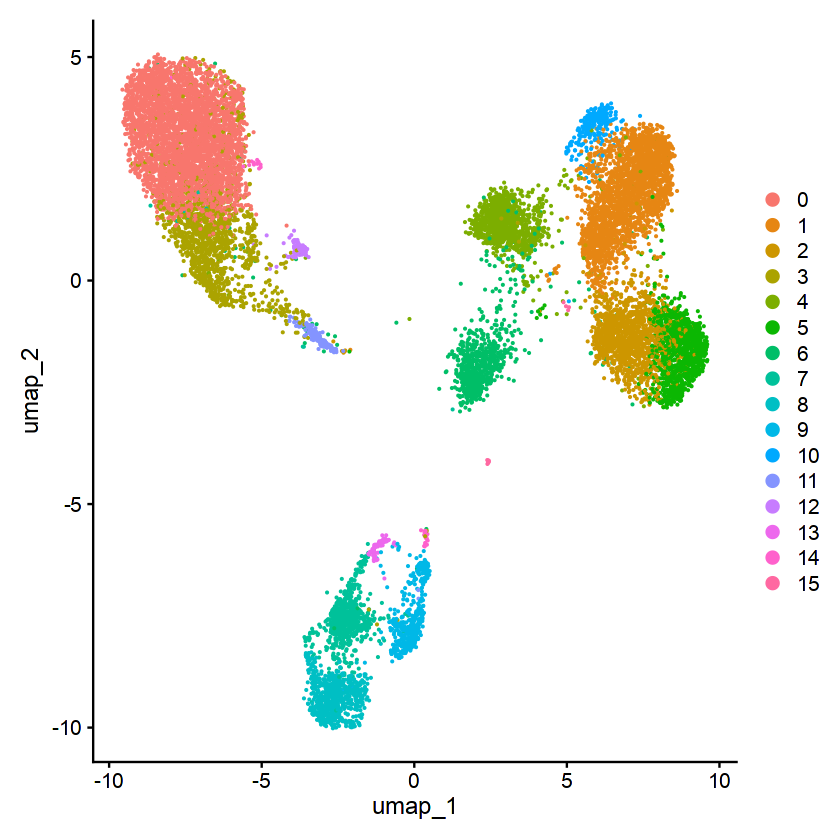

In [126]:
DimPlot(object = seurat_obj_f2, reduction = "umap")